# Import niezbędnych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


from keras.models import Sequential    
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

from prophet import Prophet
import pmdarima as pm

%matplotlib inline

sns.set_style('darkgrid')
default_fig_size = (14,12)

# Wczytanie danych i przygotowanie ich do odpowiedniego formatu

In [2]:
df = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)
df.index = df.index.map(datetime.toordinal) # zamiana daty na liczby całkowite

stocks = {}
for col in df.columns:
    stocks[col] = df[[col]]

stocks['AAPL']

AAPL
Date              
735011   13.709451
735012   13.802783
735016   13.687747
735017   13.796580
735018   14.002158
...            ...
738655  172.070007
738656  172.070007
738657  172.690002
738658  175.050003
738659  175.160004

[2516 rows x 1 columns]

# Podział na zbiór treningowy i testowy

In [3]:
# NYSE i NASDAQ - około 252 dni w roku, kiedy giełda jest otwarta - https://sortter.com/blog/article/how-many-trading-days-in-a-year/
df_without_ordinal = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df_without_ordinal.index = pd.to_datetime(df_without_ordinal.index)

stocks_without_ordinal = {}
for col in df_without_ordinal.columns:
    stocks_without_ordinal[col] = df_without_ordinal[[col]]


last_5_years = 252*5
last_year = 252

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(stocks_without_ordinal['AAPL'].index, stocks_without_ordinal['AAPL'].values, test_size=test_size, shuffle=False)
print('Dla ostatnich 10 lat:')
print('Rozmiar zbioru treningowego:', len(X_train), '| Pierwsza data:', X_train[0].strftime('%Y-%m-%d'))
print('Rozmiar zbioru testowego:', len(X_test), '| Pierwsza data:', X_test[0].strftime('%Y-%m-%d'))
print('Ostatnia data zbioru testowego:', X_test[-1].strftime('%Y-%m-%d'))

X_train, X_test, y_train, y_test = train_test_split(stocks_without_ordinal['AAPL'][-last_5_years:].index, stocks_without_ordinal['AAPL'][-last_5_years:].values, test_size=test_size, shuffle=False)
print('\nDla ostatnich 5 lat:')
print('Rozmiar zbioru treningowego:', len(X_train), '| Pierwsza data:', X_train[0].strftime('%Y-%m-%d'))
print('Rozmiar zbioru testowego:', len(X_test), '| Pierwsza data:', X_test[0].strftime('%Y-%m-%d'))
print('Ostatnia data zbioru testowego:', X_test[-1].strftime('%Y-%m-%d'))

X_train, X_test, y_train, y_test = train_test_split(stocks_without_ordinal['AAPL'][-last_year:].index, stocks_without_ordinal['AAPL'][-last_year:].values, test_size=test_size, shuffle=False)
print('\nDla ostatniego roku:')
print('Rozmiar zbioru treningowego:', len(X_train), '| Pierwsza data:', X_train[0].strftime('%Y-%m-%d'))
print('Rozmiar zbioru testowego:', len(X_test), '| Pierwsza data:', X_test[0].strftime('%Y-%m-%d'))
print('Ostatnia data zbioru testowego:', X_test[-1].strftime('%Y-%m-%d'))

Dla ostatnich 10 lat:
Rozmiar zbioru treningowego: 2012 | Pierwsza data: 2013-05-23
Rozmiar zbioru testowego: 504 | Pierwsza data: 2021-05-20
Ostatnia data zbioru testowego: 2023-05-19

Dla ostatnich 5 lat:
Rozmiar zbioru treningowego: 1008 | Pierwsza data: 2018-05-18
Rozmiar zbioru testowego: 252 | Pierwsza data: 2022-05-19
Ostatnia data zbioru testowego: 2023-05-19

Dla ostatniego roku:
Rozmiar zbioru treningowego: 201 | Pierwsza data: 2022-05-19
Rozmiar zbioru testowego: 51 | Pierwsza data: 2023-03-09
Ostatnia data zbioru testowego: 2023-05-19


# Funkcje pomocnicze

In [4]:
def evaluate_model(y_test, y_pred):
    r2 = np.round(r2_score(y_test, y_pred), 2)
    mse = np.round(mean_squared_error(y_test, y_pred), 2)
    mae = np.round(mean_absolute_error(y_test, y_pred), 2)

    df = pd.DataFrame(data=[r2, mse, mae], index=['R2', 'MSE', 'MAE'], columns=['Wartość'])
    return df

# Regresja liniowa

In [5]:
def linear_regression_model(data, ax):
        X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
        X_train = X_train.values.reshape(-1, 1)
        X_test = X_test.values.reshape(-1, 1)

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_pred = lr.predict(X_test)

        ax.plot(X_train, y_train, label='train')
        ax.plot(X_train, y_train_pred, label='train pred')
        ax.plot(X_test, y_test, label='test')
        ax.plot(X_test, y_pred, label='pred')
        ax.legend(loc=2)
        ax.set_title(stock)

        results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

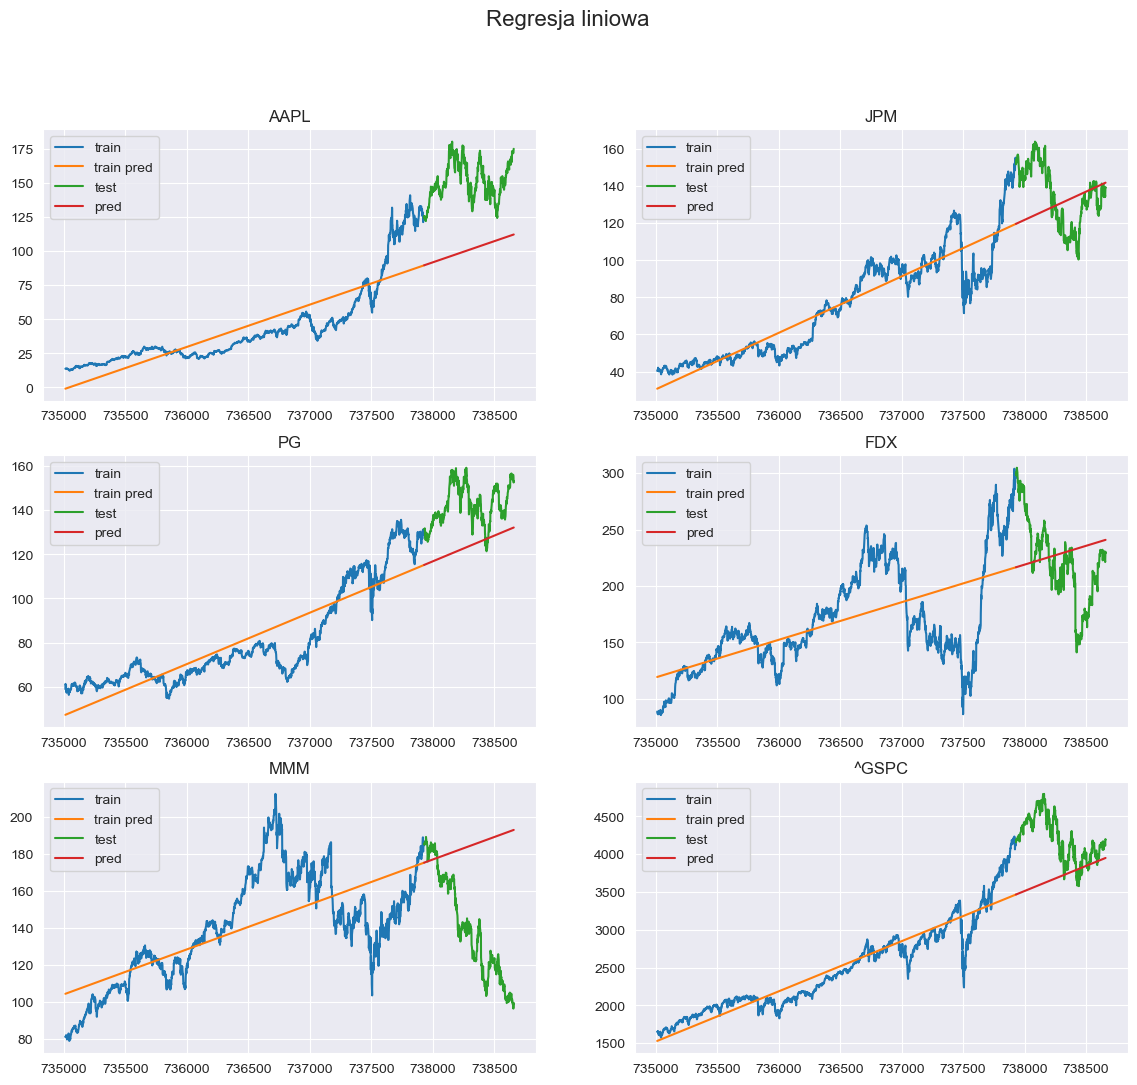

AAPL     JPM      PG      FDX      MMM      ^GSPC
R2    -14.36   -0.68   -4.38    -0.36    -2.96      -3.80
MSE  2780.08  427.91  419.00  1727.05  2945.69  398230.17
MAE    50.86   17.31   18.63    32.80    45.52     507.07

In [6]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

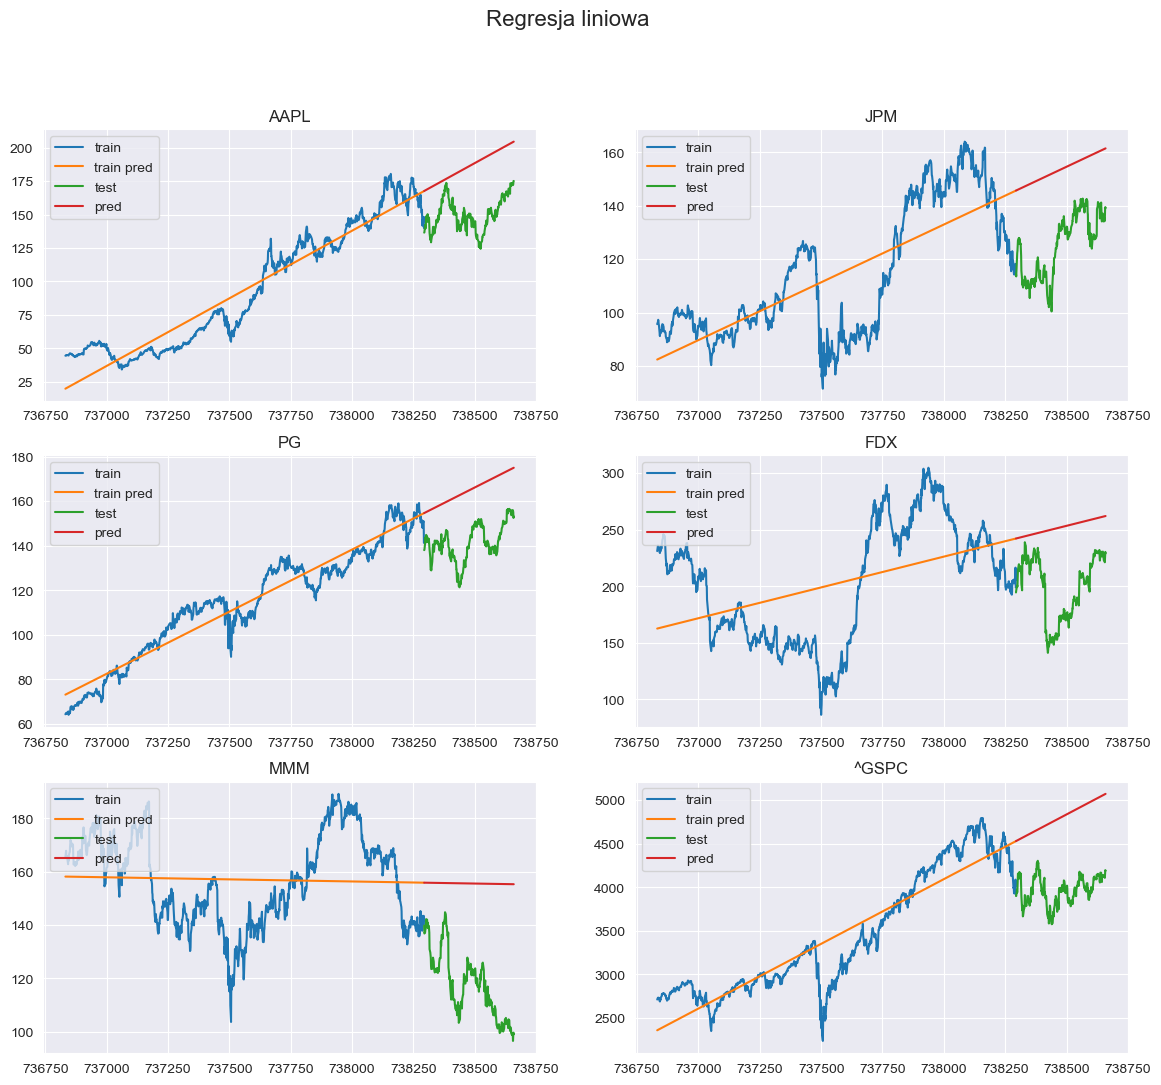

AAPL     JPM      PG      FDX      MMM      ^GSPC
R2     -9.28   -5.63   -8.48    -3.79    -9.59     -29.30
MSE  1468.87  900.34  603.83  3568.86  1603.32  735499.62
MAE    36.01   28.73   23.47    53.03    38.15     837.18

In [7]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

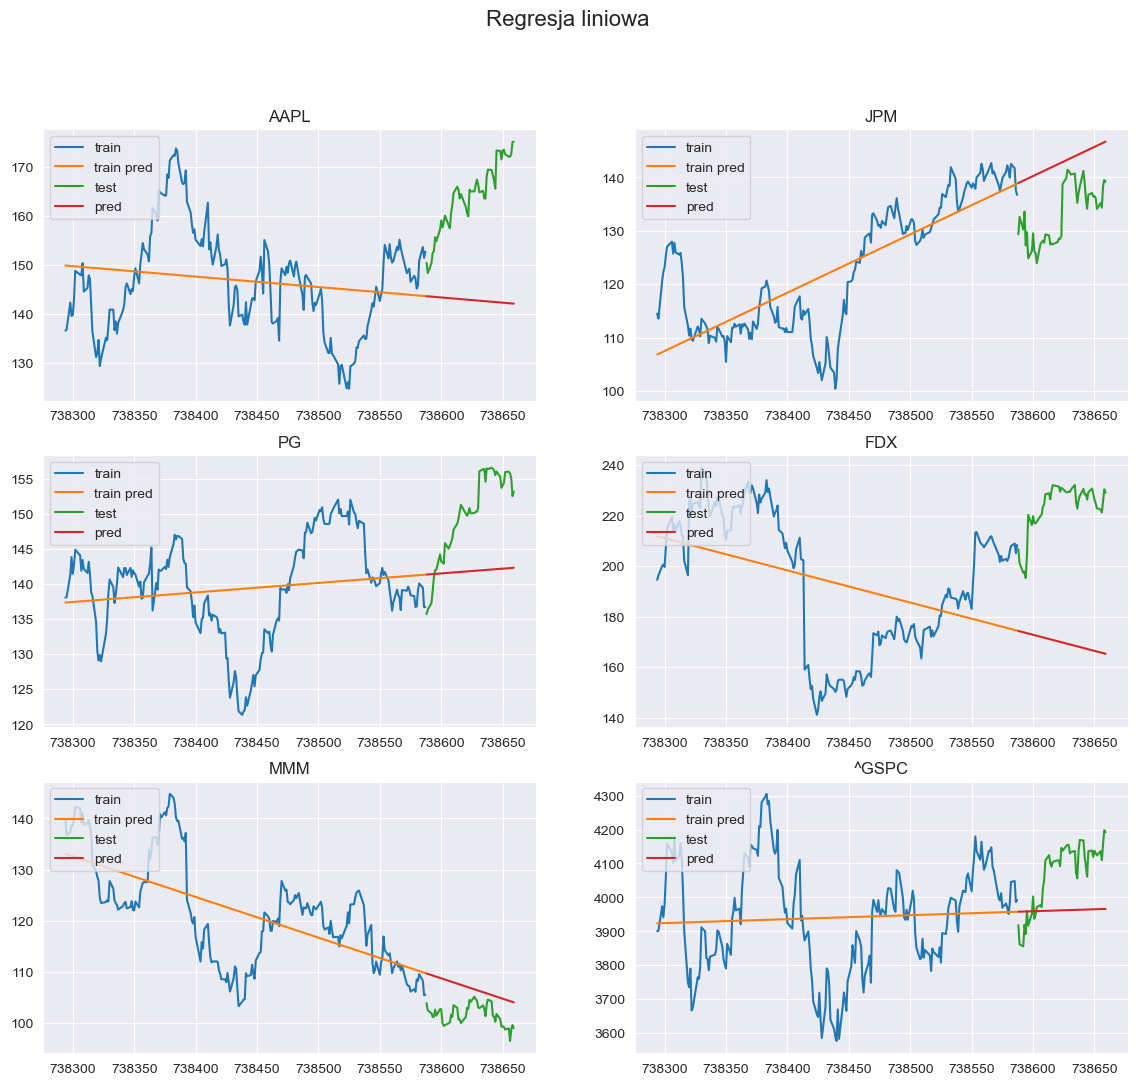

AAPL     JPM     PG      FDX    MMM     ^GSPC
R2    -9.76   -2.93  -1.70   -32.41  -7.46     -1.35
MSE  504.94  110.94  94.98  2993.96  32.00  19885.04
MAE   21.26    9.74   8.62    53.52   5.23    125.28

In [8]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Regresja wielomianowa

In [9]:
def polynomial_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    poly_reg = PolynomialFeatures(degree=4)
    X_train_poly = poly_reg.fit_transform(X_train)
    X_test_poly = poly_reg.fit_transform(X_test)

    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    y_train_pred = poly_reg.predict(X_train_poly)
    y_pred = poly_reg.predict(X_test_poly)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

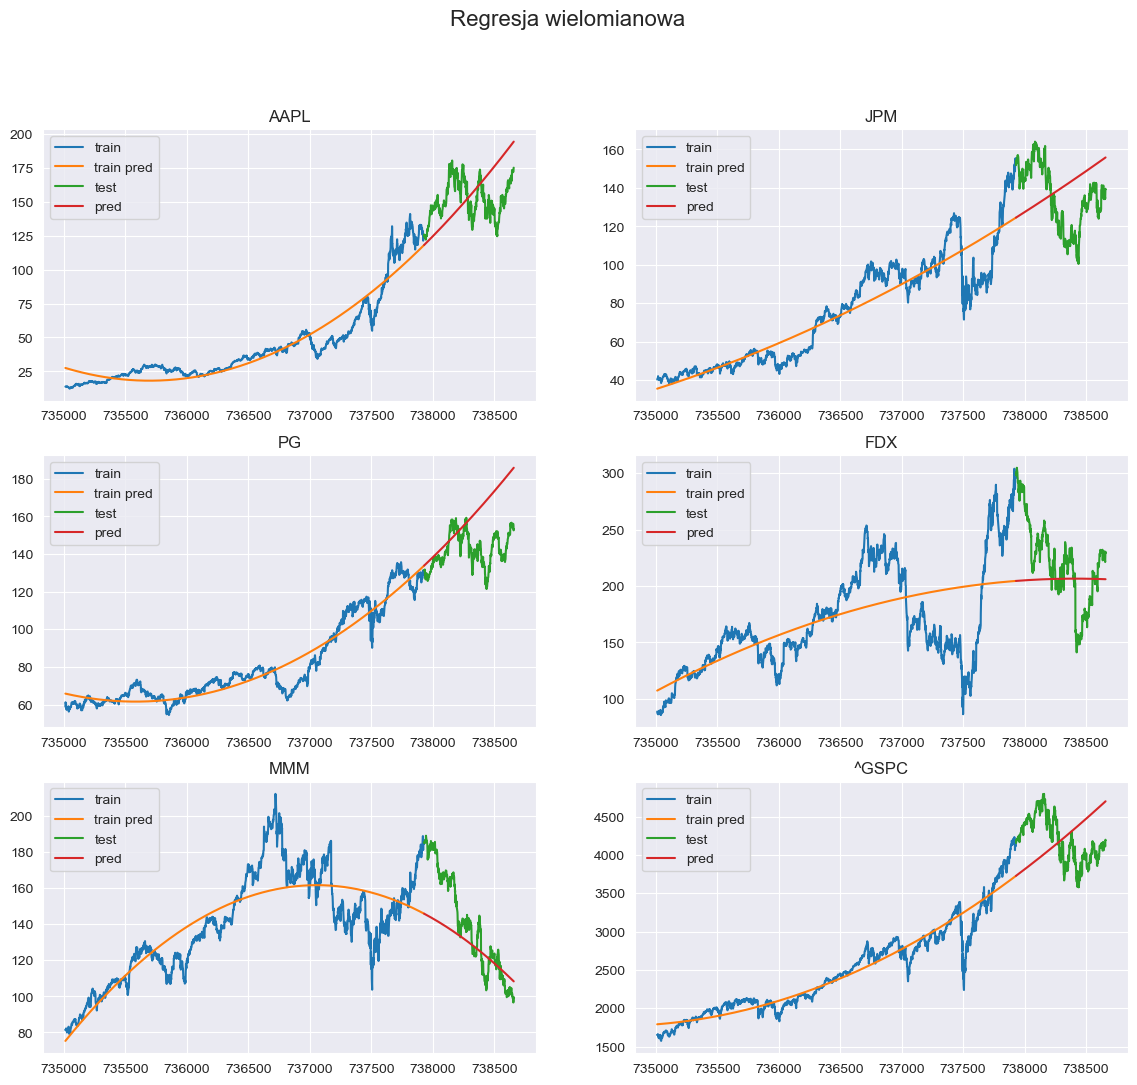

AAPL     JPM      PG      FDX     MMM      ^GSPC
R2    -2.20   -1.02   -5.49    -0.20    0.42      -2.23
MSE  578.24  512.70  506.07  1519.73  427.44  268532.73
MAE   21.31   20.95   17.61    30.64   16.14     484.43

In [10]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

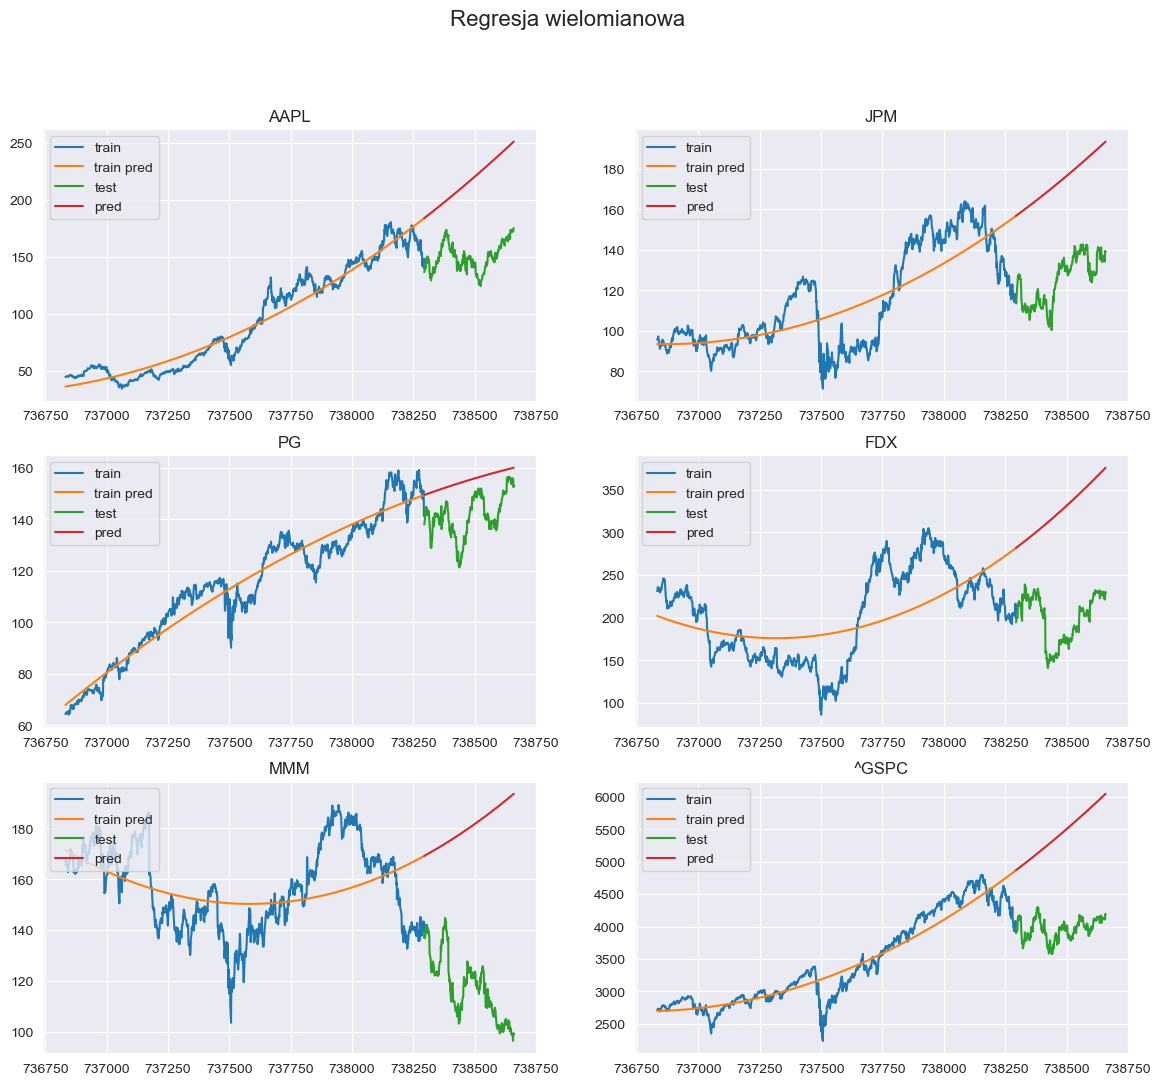

AAPL      JPM      PG       FDX      MMM       ^GSPC
R2    -32.46   -17.57   -2.72    -22.56   -27.61      -93.16
MSE  4782.88  2520.01  237.25  17542.40  4331.69  2285660.23
MAE    66.47    49.60   13.67    127.27    63.17     1475.33

In [11]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

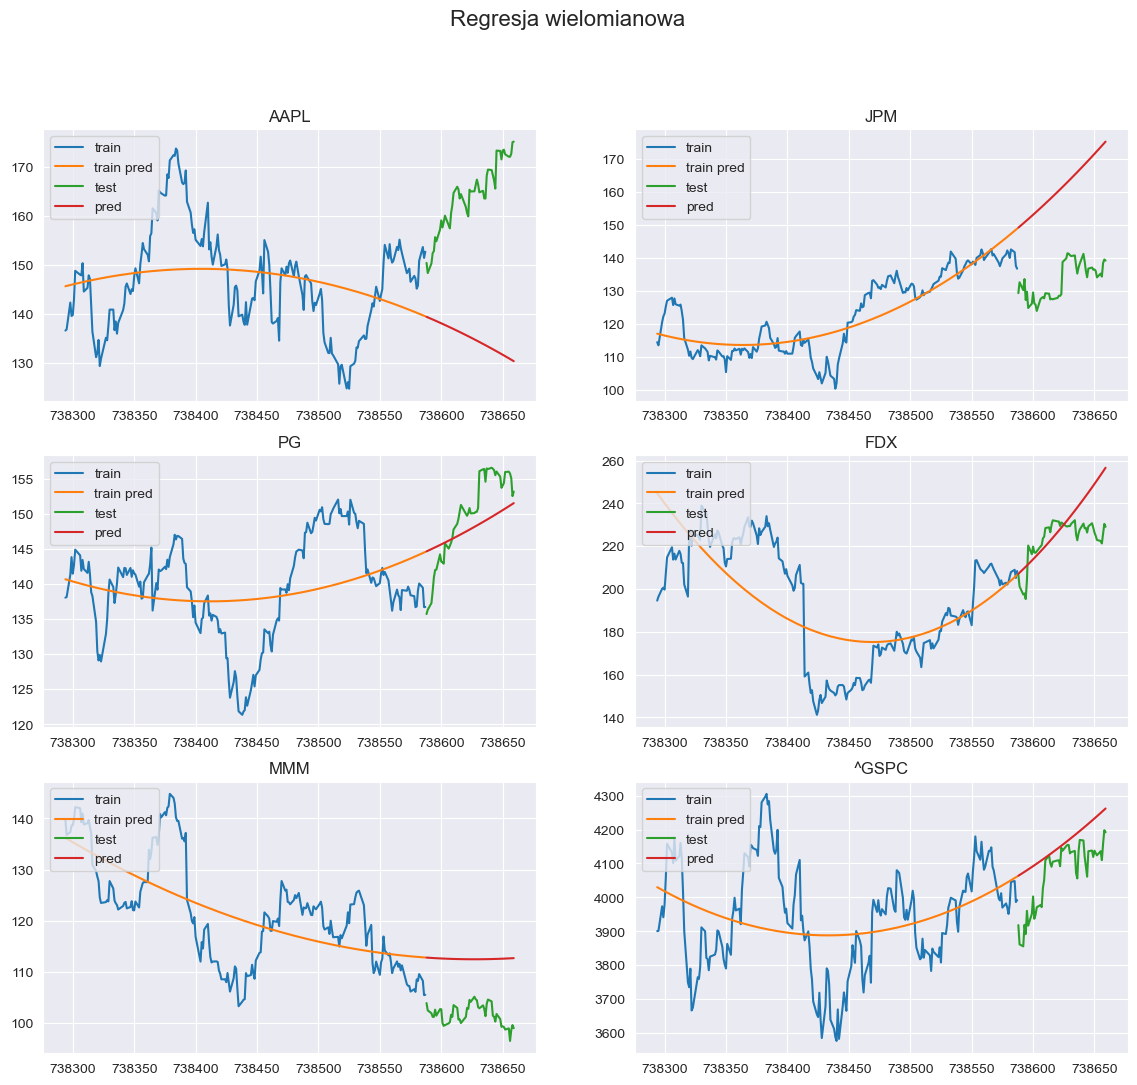

AAPL     JPM     PG     FDX     MMM     ^GSPC
R2   -18.92  -29.21   0.41   -1.16  -31.88     -0.29
MSE  935.08  852.48  20.77  193.50  124.34  10924.73
MAE   29.09   28.68   3.89   10.70   10.97     88.41

In [12]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Support Vector Machine

In [13]:
def svm_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    svr = make_pipeline(StandardScaler(), SVR(C=2, epsilon=0.2))
    svr.fit(X_train, y_train)
    y_train_pred = svr.predict(X_train)
    y_pred = svr.predict(X_test)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

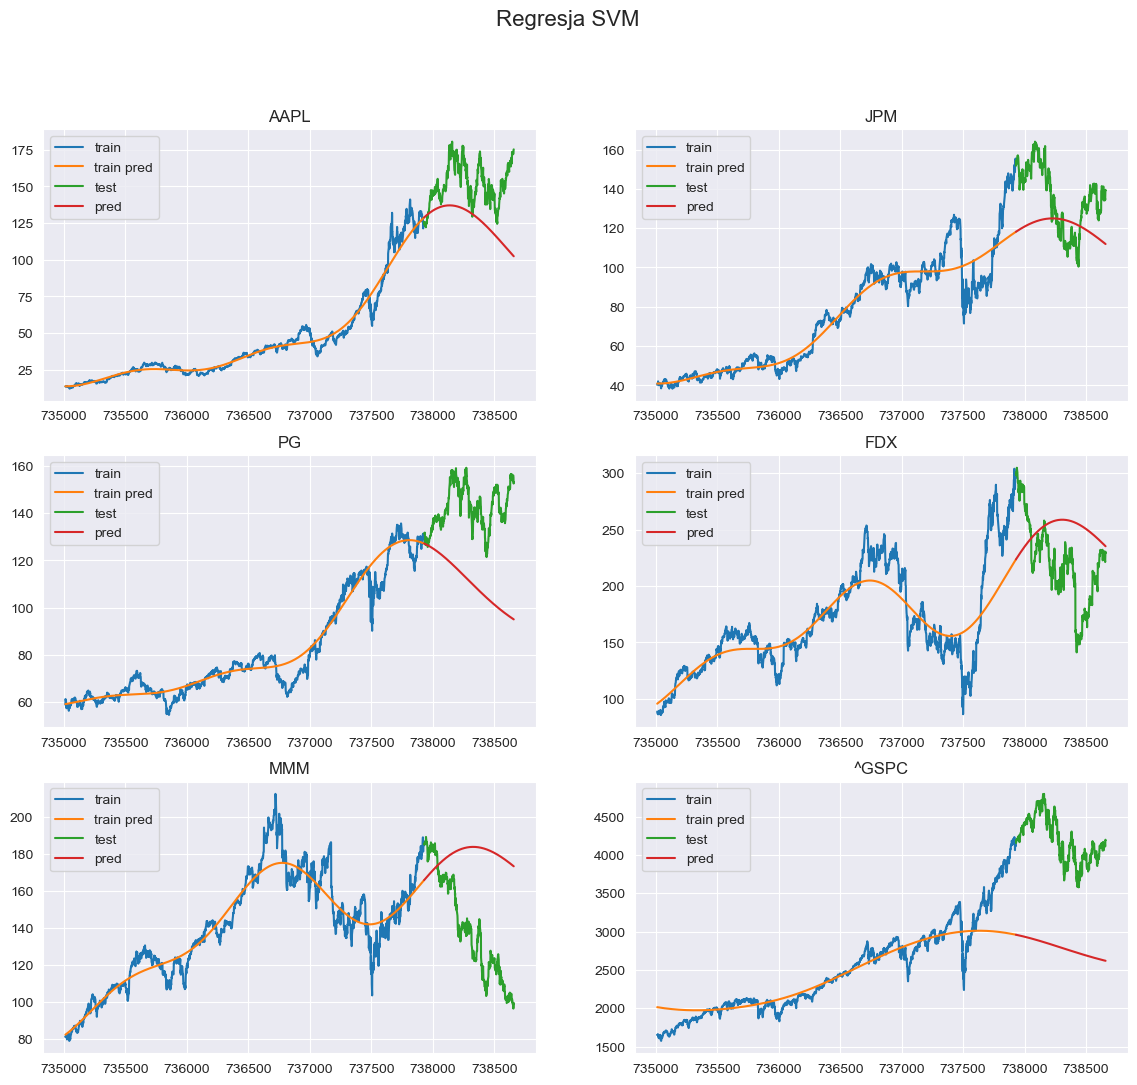

AAPL     JPM       PG      FDX      MMM       ^GSPC
R2    -4.01   -0.85   -13.97    -0.99    -2.17      -23.58
MSE  905.83  470.97  1166.73  2523.37  2353.16  2040847.67
MAE   25.42   18.95    30.75    42.18    42.03     1409.57

In [14]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

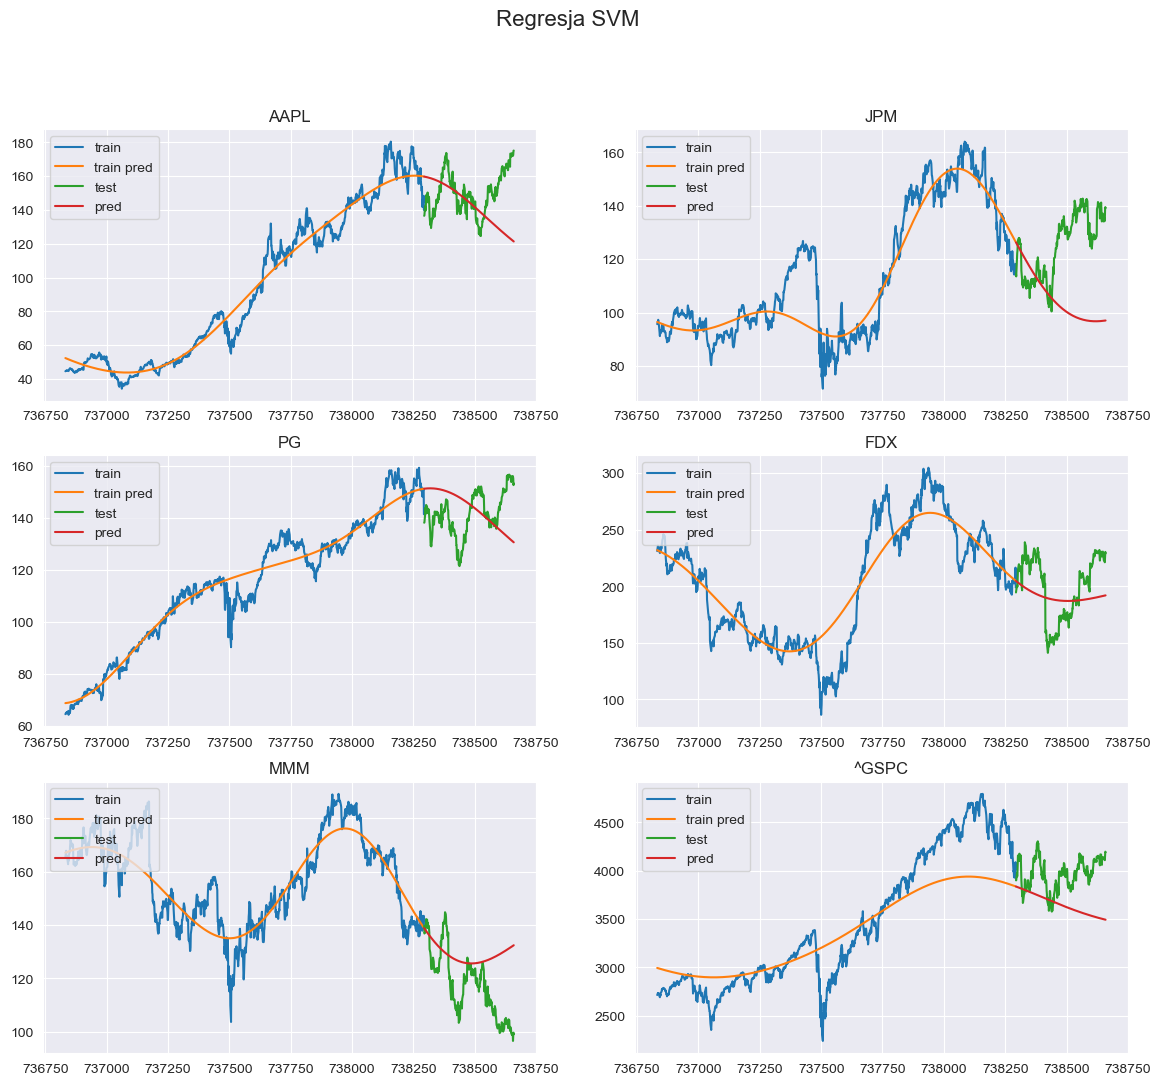

AAPL     JPM      PG     FDX     MMM      ^GSPC
R2    -2.04   -4.50   -1.70    0.05   -0.80      -4.88
MSE  435.25  746.85  172.35  709.43  272.94  142626.87
MAE   15.68   22.25   10.87   23.74   13.51     324.89

In [15]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

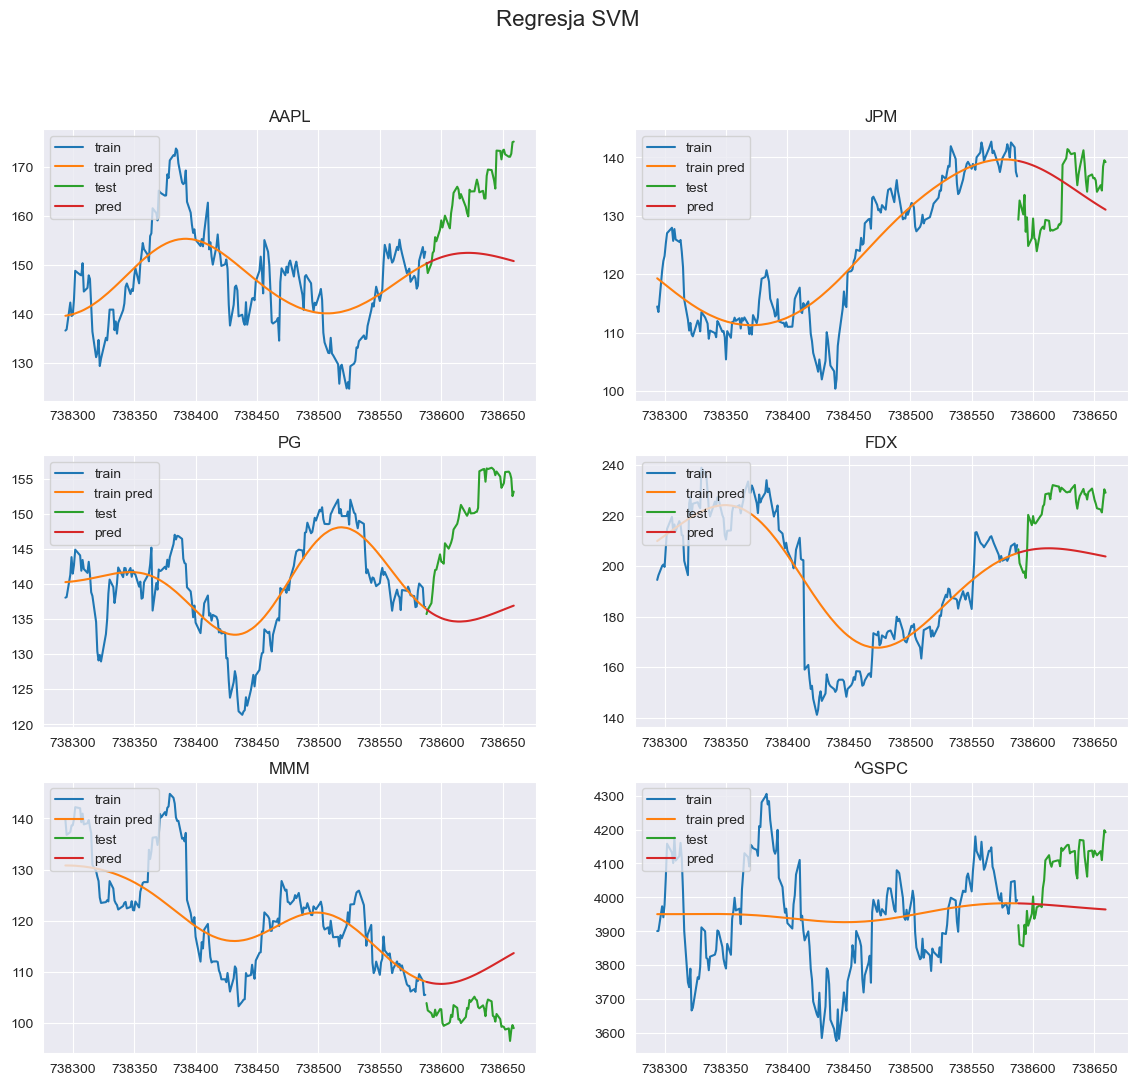

AAPL    JPM      PG     FDX    MMM     ^GSPC
R2    -3.22  -1.18   -5.76   -3.33 -19.37     -1.20
MSE  198.16  61.55  238.20  388.31  77.05  18665.77
MAE   12.44   7.11   14.32   18.60   8.14    122.89

In [16]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Decision Tree Based Regression

In [17]:
def decision_tree_based_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    # y_train = y_train.ravel()
    # y_test = y_test.ravel()

    dt = DecisionTreeRegressor(max_depth=8)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    y_pred = dt.predict(X_test)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

### Wyniki dla ostatnich 10 lat

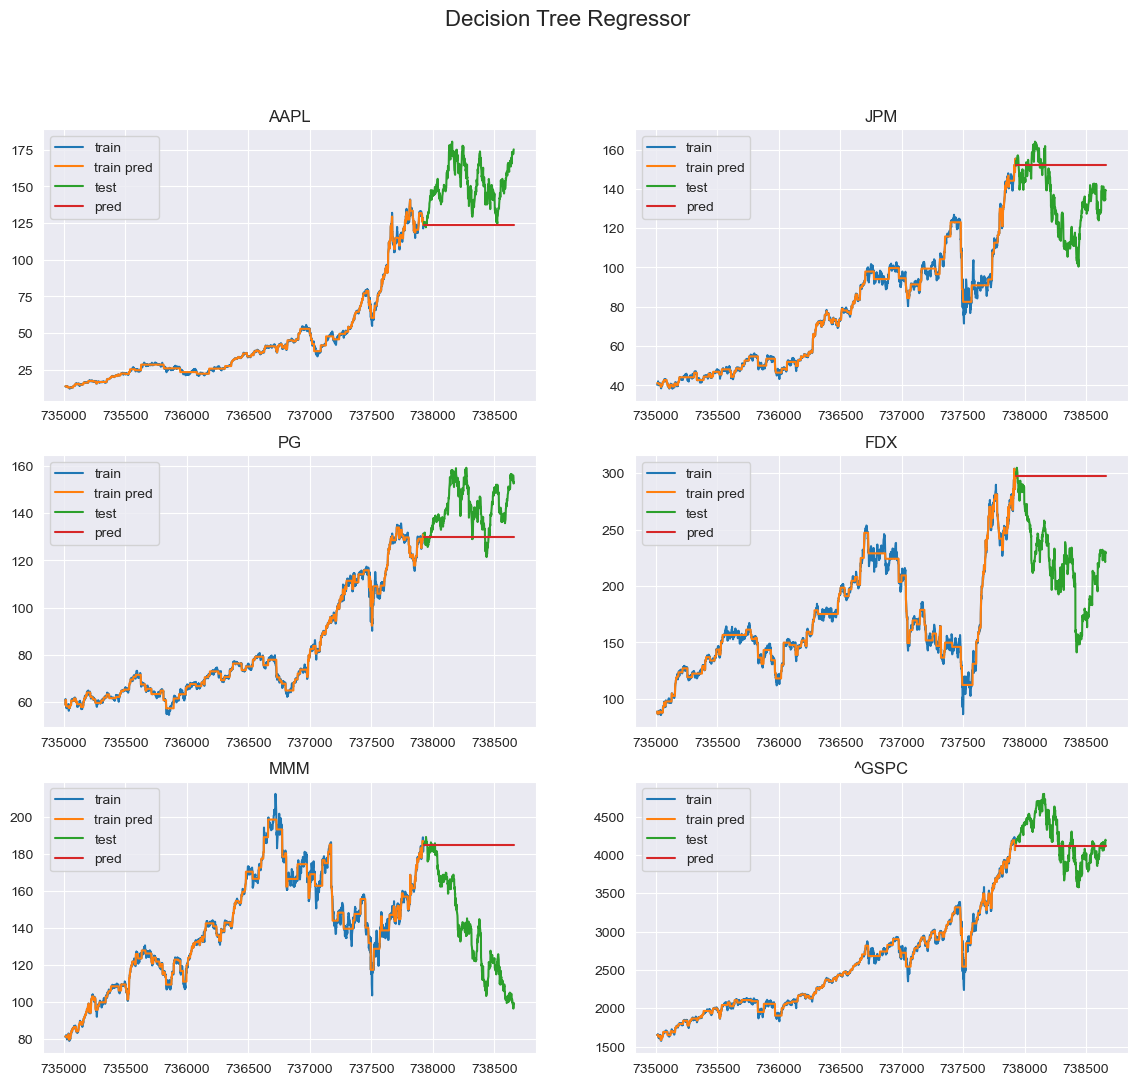

AAPL     JPM      PG      FDX      MMM     ^GSPC
R2    -4.36   -1.10   -1.88    -4.63    -2.67     -0.07
MSE  970.63  534.04  224.69  7145.89  2729.39  89248.82
MAE   28.11   18.59   12.72    76.77    44.66    246.66

In [18]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Decision Tree Regressor', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        decision_tree_based_regression_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

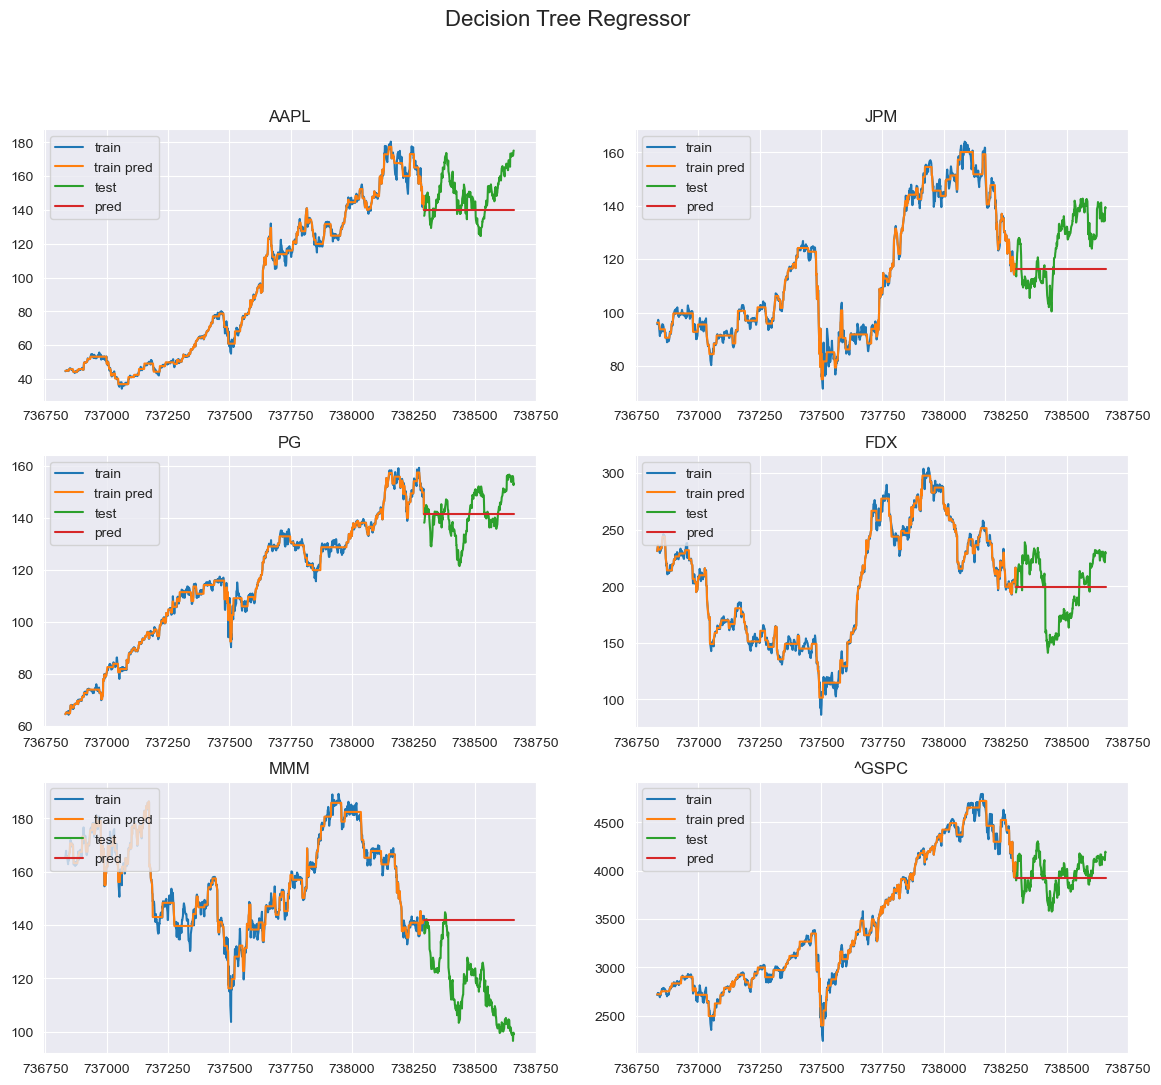

AAPL     JPM     PG     FDX     MMM     ^GSPC
R2    -0.73   -0.56  -0.00   -0.00   -3.92     -0.08
MSE  247.65  211.60  63.74  744.62  745.01  26147.13
MAE   12.64   12.42   6.22   23.88   24.43    134.44

In [19]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Decision Tree Regressor', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        decision_tree_based_regression_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

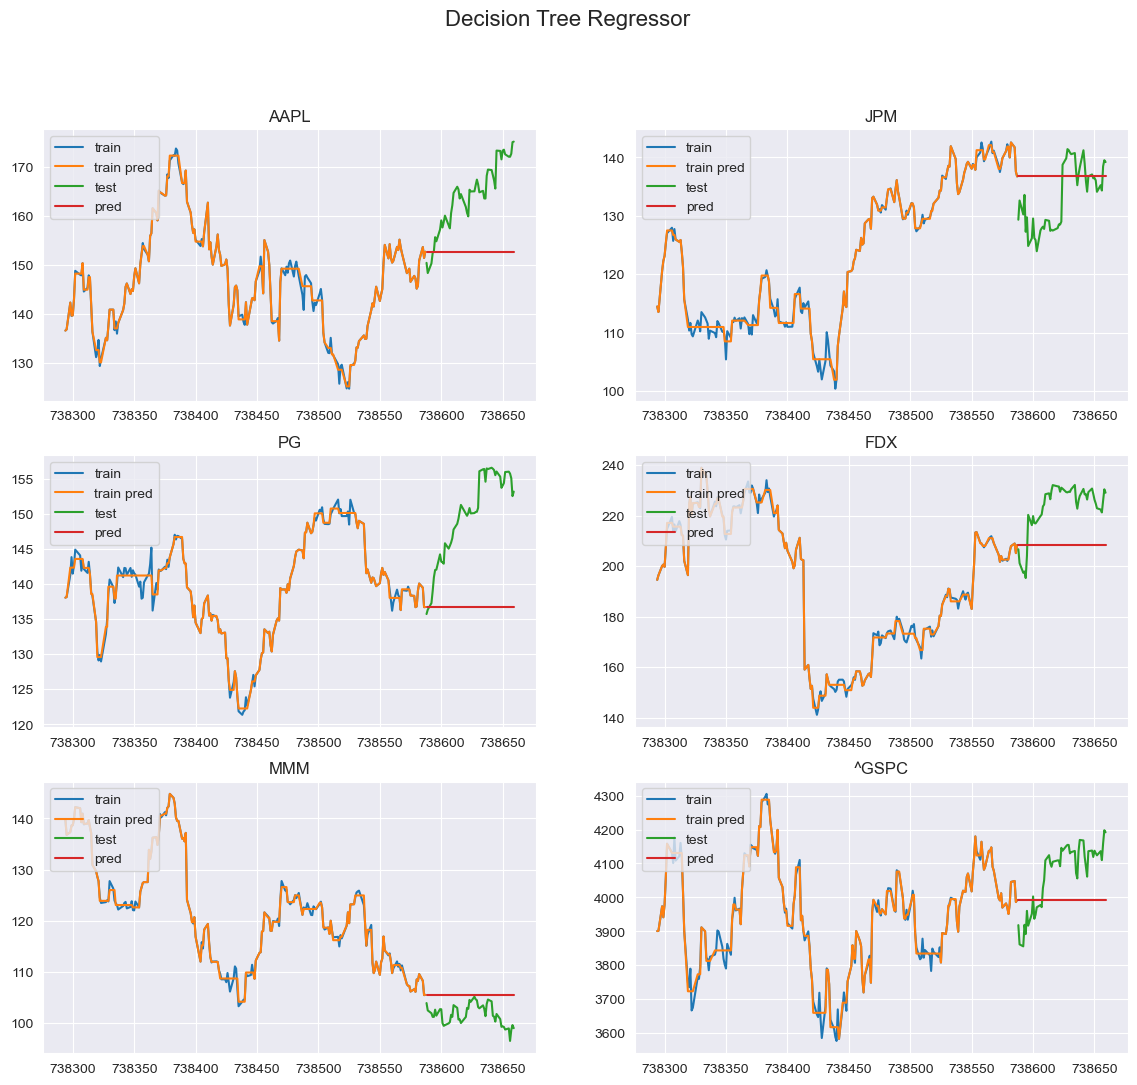

AAPL    JPM      PG     FDX    MMM     ^GSPC
R2    -2.76  -0.45   -4.83   -2.47  -4.10     -0.73
MSE  176.68  41.03  205.23  311.25  19.29  14649.21
MAE   11.76   5.26   13.09   16.76   3.94    110.55

In [20]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Decision Tree Regressor', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        decision_tree_based_regression_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Model LSTM

In [21]:
def window_data(data, stock, n=3):
    windowed_data = pd.DataFrame()
    windowed_data['Target Date'] = data['Date']
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data[stock].shift(i)
    windowed_data['Target'] = data[stock] # Target is a value to be predicted, other columns are features
    return windowed_data.dropna()

def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0] # All rows, just the first column
    middle_matrix = df_as_np[:, 1:-1] # All but first and last columns
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1) # Reshape to 3D array
    y = df_as_np[:, -1] # Just the last column
    return dates, X.astype(np.float32), y.astype(np.float32)

In [22]:
df_lstm = pd.read_csv('data/close_prices_clean.csv', parse_dates=True)
df_lstm['Date'] = pd.to_datetime(df_lstm['Date'])

stocks_lstm = {}
for col in df_lstm.columns[1:]:
    stocks_lstm[col] = df_lstm[['Date', col]]

stocks_lstm['^GSPC'].head()

Date        ^GSPC
0 2013-05-23  1650.510010
1 2013-05-24  1649.599976
2 2013-05-28  1660.060059
3 2013-05-29  1648.359985
4 2013-05-30  1654.410034

In [23]:
def lstm_recursive_model(data, stock, ax):
    windowed_df = window_data(data, stock, n=10)
    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    test_split = int(len(X) * 0.8)

    dates_train, X_train, y_train = dates[:test_split], X[:test_split], y[:test_split]
    dates_test, X_test, y_test = dates[test_split:], X[test_split:], y[test_split:]

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    architecture_img_file = 'LSTM_model.png'
    # plot_model(model, to_file=architecture_img_file, show_shapes=True)
    model.fit(X_train, y_train, epochs=100, verbose=0)

    recursive_predictions = []
    recursive_dates = dates_test
    last_window = deepcopy(X_train[-1])

    for target_date in recursive_dates:
        next_prediction = model.predict(np.array([last_window])).flatten()
        recursive_predictions.append(next_prediction)
        new_window = list(last_window[1:])
        new_window.append(next_prediction)
        new_window = np.array(new_window)
        last_window = new_window

    y_train_pred = model.predict(X_train) 
    y_test_pred = model.predict(X_test)

    y_pred_naive = np.roll(y_test, 1)[1:]
    y_pred_naive = np.insert(y_pred_naive, 0, y_train[-1])


    ax.plot(dates_train, y_train, label='Train')
    ax.plot(dates_train, y_train_pred, label='Train Predictions')
    ax.plot(dates_test, y_test, label='Test')
    ax.plot(dates_test, y_test_pred, label='Test Predictions')
    ax.plot(recursive_dates, recursive_predictions, label='Recursive Predictions')
    ax.plot(dates_test, y_pred_naive, label='Naive Prediction')
    ax.legend(loc=2)
    ax.set_title(stock)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    results_df[stock] = evaluate_model(y_test, recursive_predictions)['Wartość']

### Wyniki dla ostatnich 10 lat

2023-05-21 23:52:32.108199: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 2ms/step


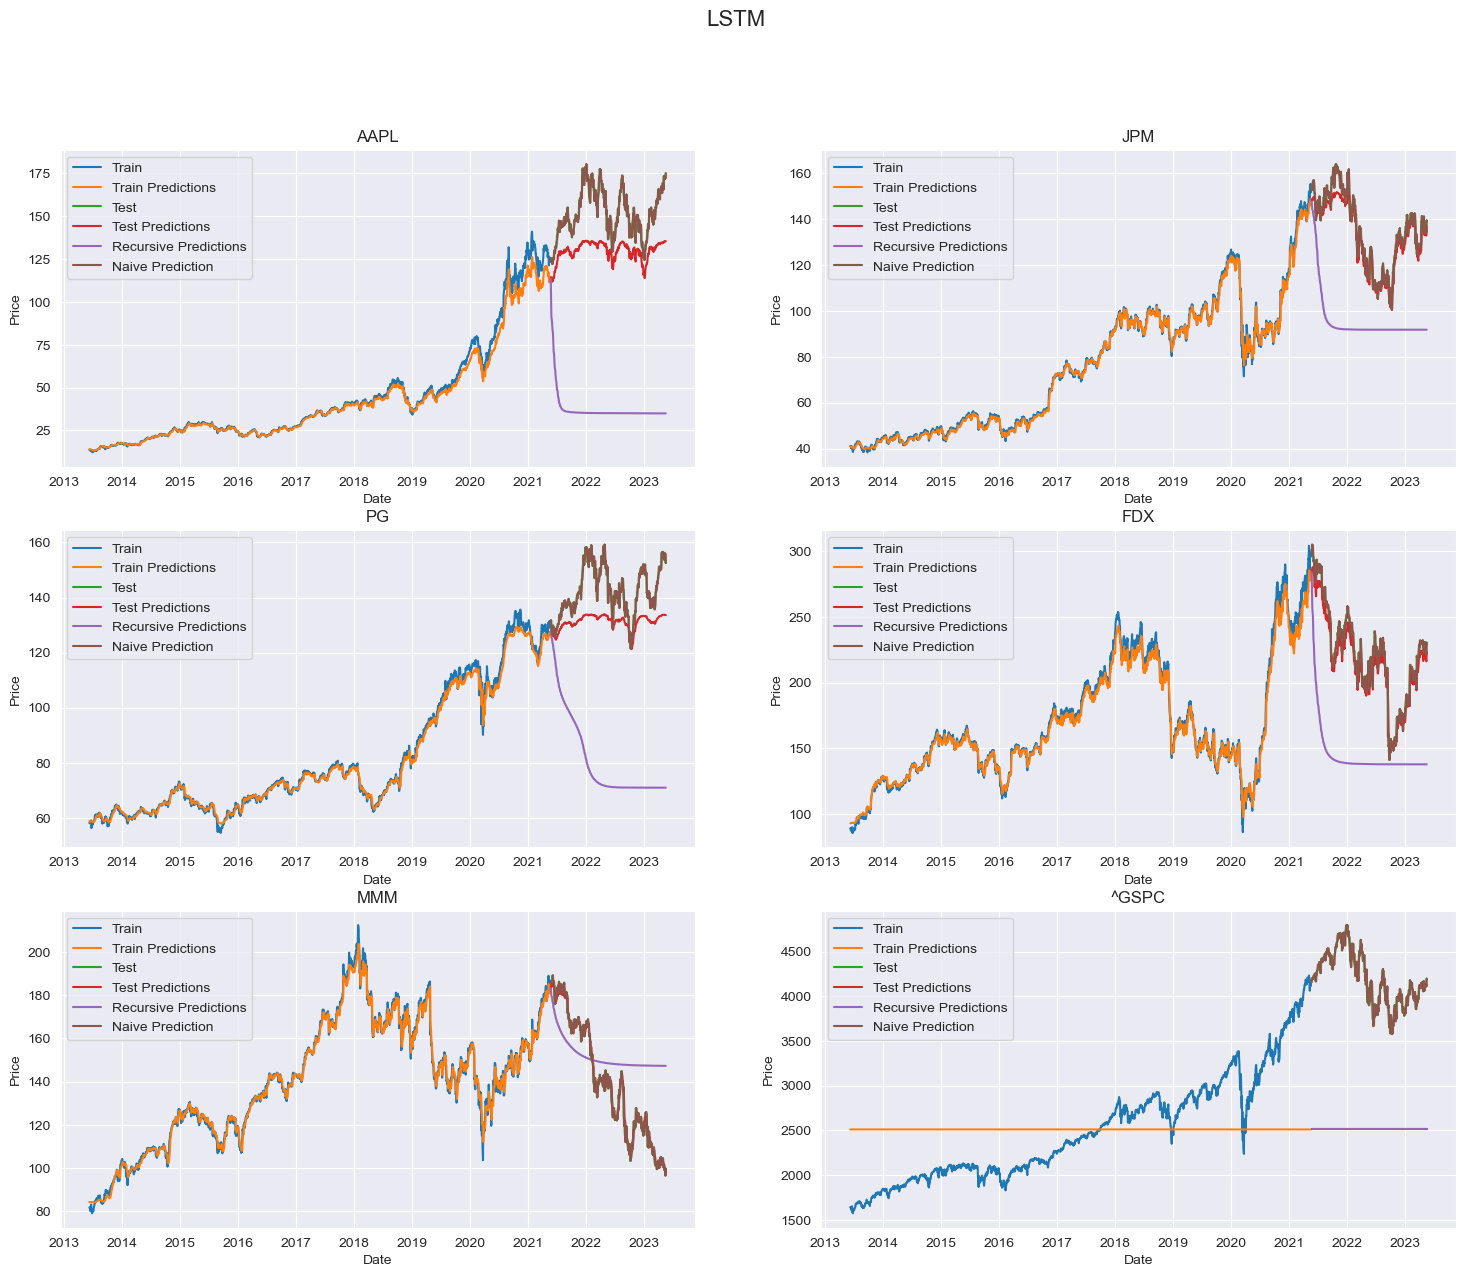

AAPL          JPM           PG          FDX         MMM  \
R2     -74.270000    -6.250000   -52.790000    -4.200000    0.160000   
MSE  13457.219727  1840.900024  4183.200195  6491.410156  618.570007   
MAE    114.309998    39.660000    61.320000    75.540001   21.240000   

            ^GSPC  
R2  -3.426000e+01  
MSE  2.939029e+06  
MAE  1.689880e+03

In [24]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_lstm):
    lstm_recursive_model(stocks_lstm[stock], stock, ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

8/8 [==============================] - 0s 2ms/step


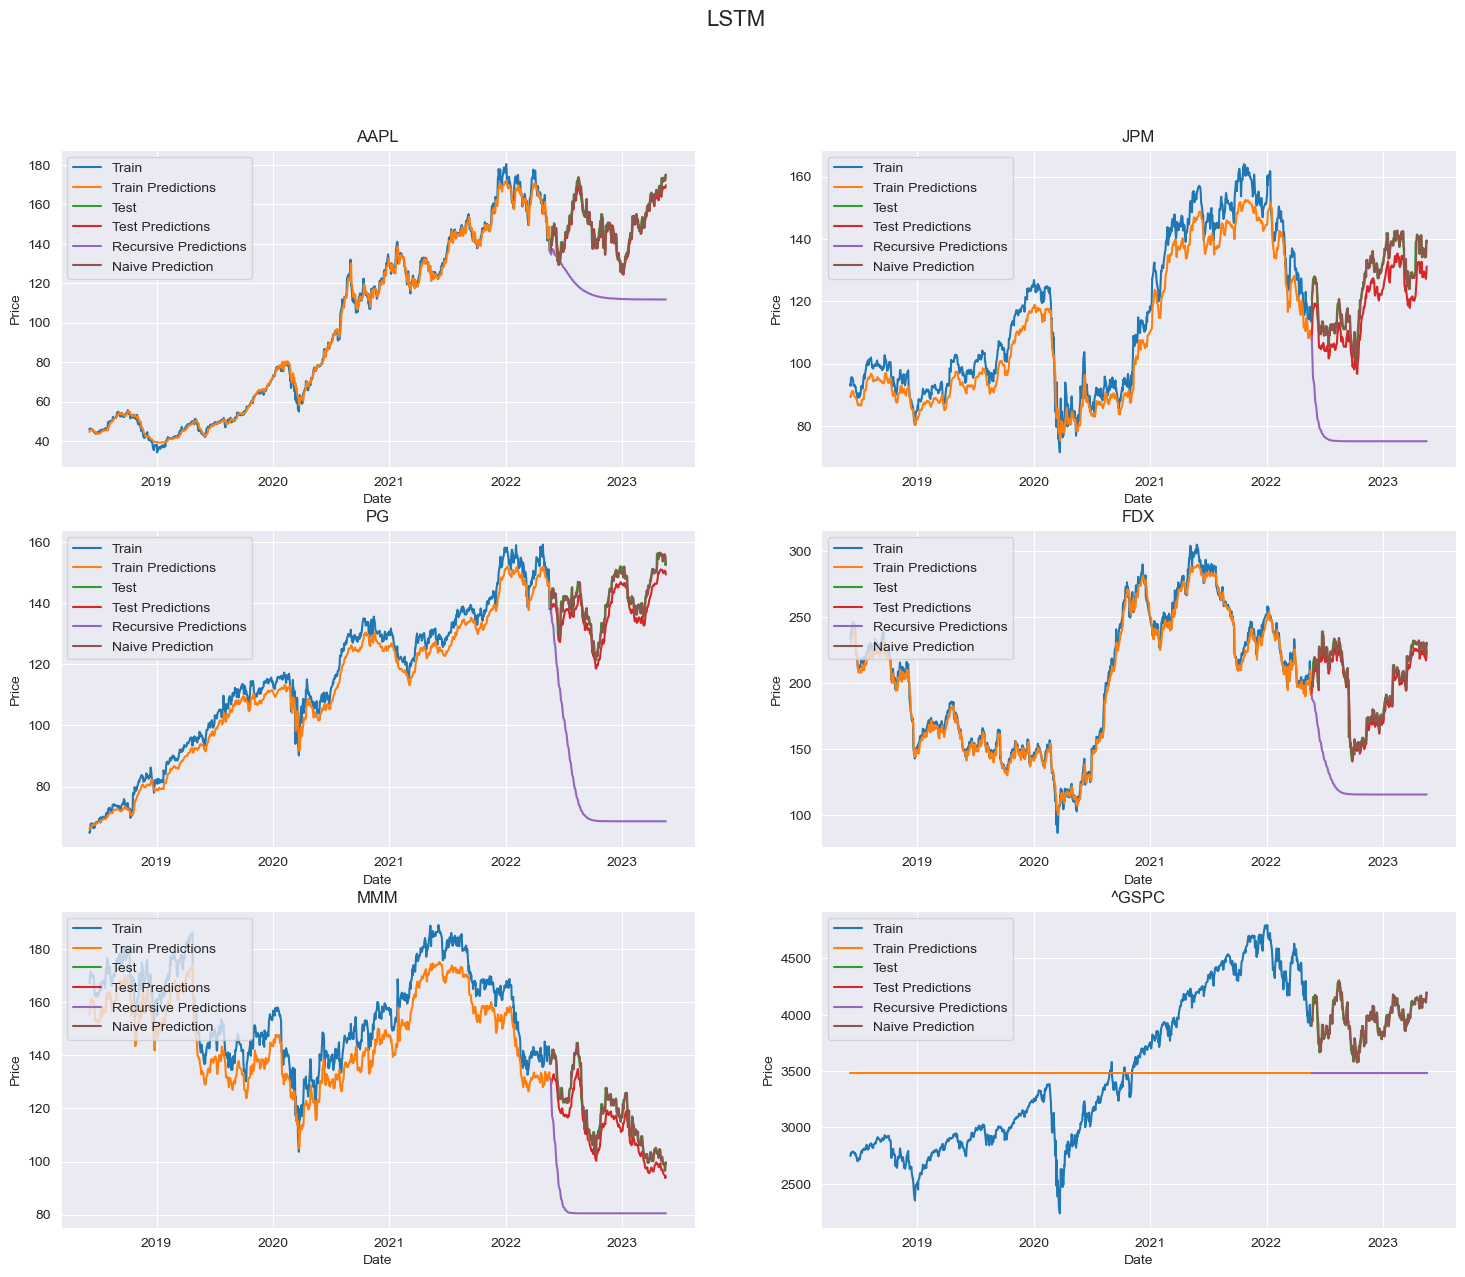

AAPL          JPM           PG          FDX          MMM  \
R2     -8.690000   -17.700000   -69.820000    -7.870000    -7.820000   
MSE  1382.180054  2540.189941  4542.330078  6657.200195  1315.589966   
MAE    34.080002    48.750000    64.500000    76.610001    34.509998   

             ^GSPC  
R2       -9.570000  
MSE  258331.546875  
MAE     483.630005

In [25]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_lstm):
    lstm_recursive_model(stocks_lstm[stock][-last_5_years:], stock, ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

2/2 [==============================] - 0s 2ms/step


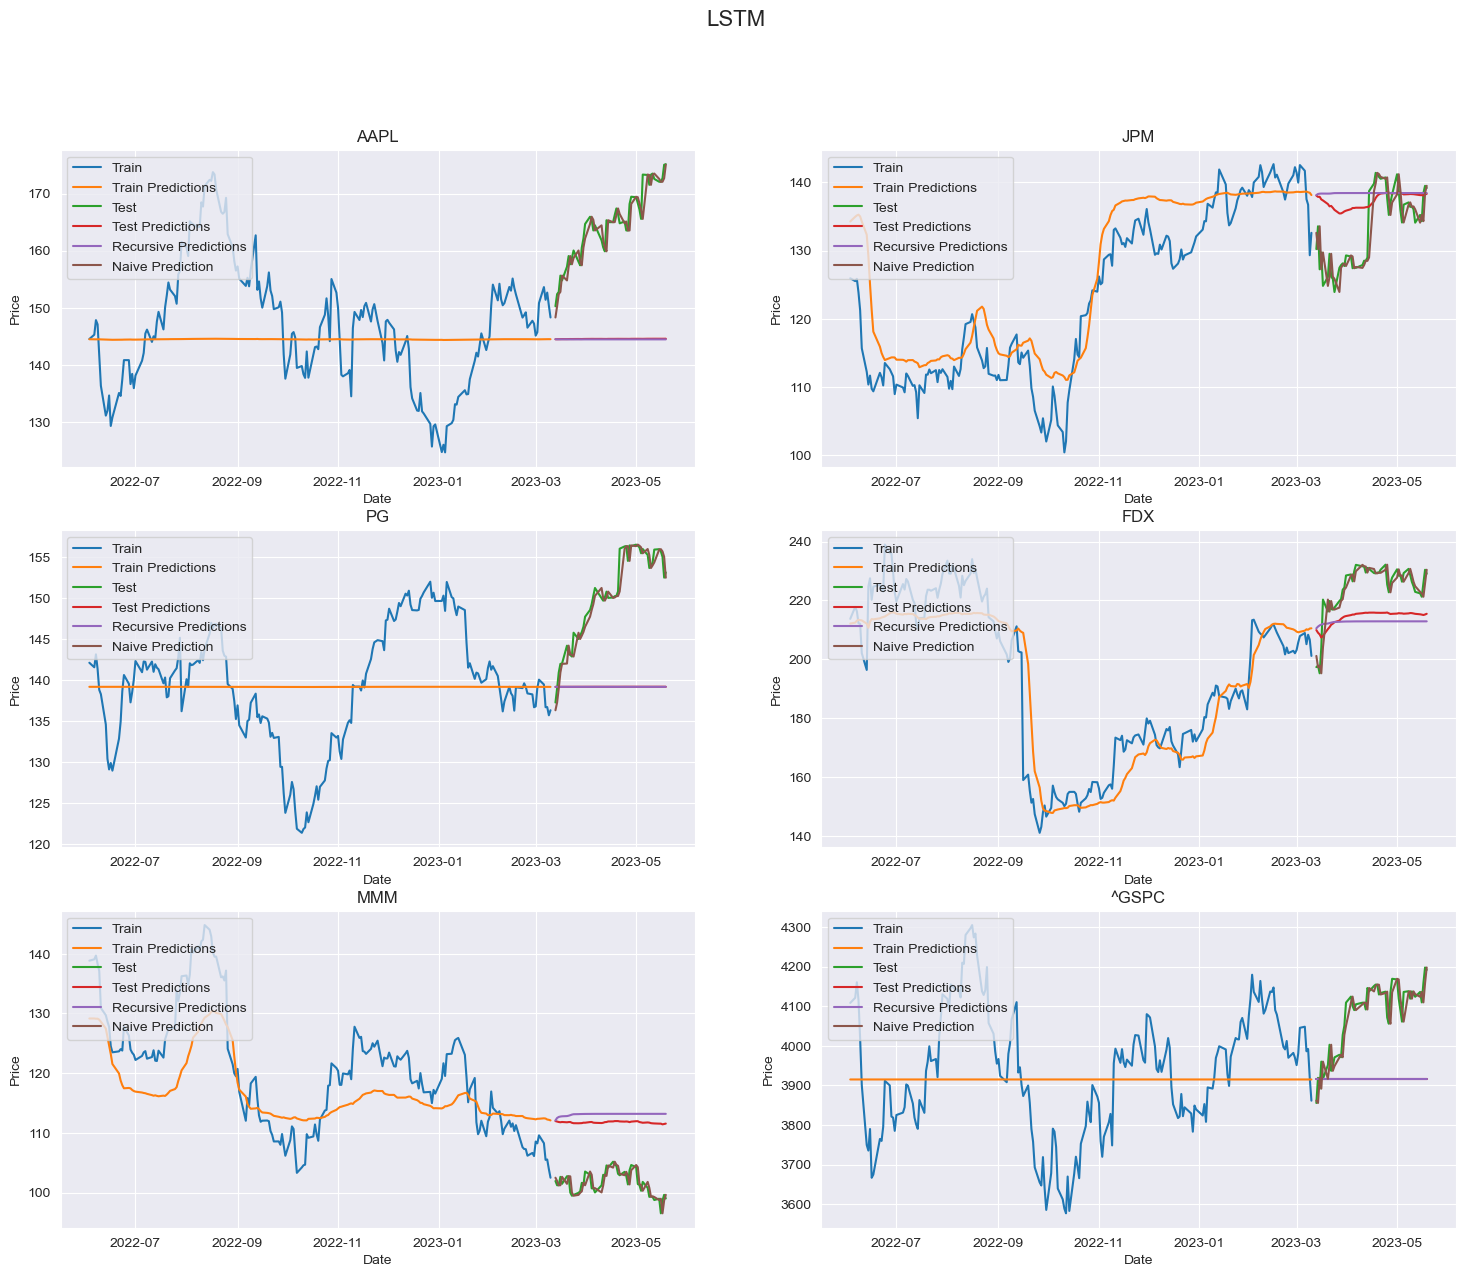

AAPL        JPM          PG         FDX         MMM         ^GSPC
R2   -10.290000  -0.920000   -4.320000   -1.570000  -35.090000     -3.580000
MSE  447.339996  55.799999  152.479996  198.240005  137.330002  33901.648438
MAE   20.190001   5.970000   11.210000   13.400000   11.550000    166.160004

In [26]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_lstm):
    lstm_recursive_model(stocks_lstm[stock][-last_year:], stock, ax)

plt.show()
results_df

# Prophet

In [27]:
df_prophet = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df_prophet.index = pd.DatetimeIndex(df_prophet.index)
stocks_prophet = {}
for col in df_prophet.columns:
    stocks_prophet[col] = df_prophet[[col]]


def prophet_model(data, ax):
    data = data.reset_index().rename(columns={'Date':'ds', data.columns[0]:'y'})
    X_train, X_test, y_train, y_test = train_test_split(data, data.y, test_size=test_size, shuffle=False)
    m = Prophet(daily_seasonality=True)
    m.fit(X_train)

    future = m.make_future_dataframe(periods=len(X_test)) #we need to specify the number of days in future
    y_pred = m.predict(future)
    y_pred_values = y_pred[['ds', 'yhat']].set_index('ds') # for evaluation

    ax.plot(X_train.ds, y_train, label='train')
    ax.plot(X_test.ds, y_test, label='test')
    m.plot(y_pred, ax=ax)
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred_values.yhat[-len(y_test):].values)['Wartość']

### Wyniki dla ostatnich 10 lat

00:00:26 - cmdstanpy - INFO - Chain [1] start processing
00:00:26 - cmdstanpy - INFO - Chain [1] done processing
00:00:27 - cmdstanpy - INFO - Chain [1] start processing
00:00:27 - cmdstanpy - INFO - Chain [1] done processing
00:00:28 - cmdstanpy - INFO - Chain [1] start processing
00:00:28 - cmdstanpy - INFO - Chain [1] done processing
00:00:29 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing
00:00:31 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing


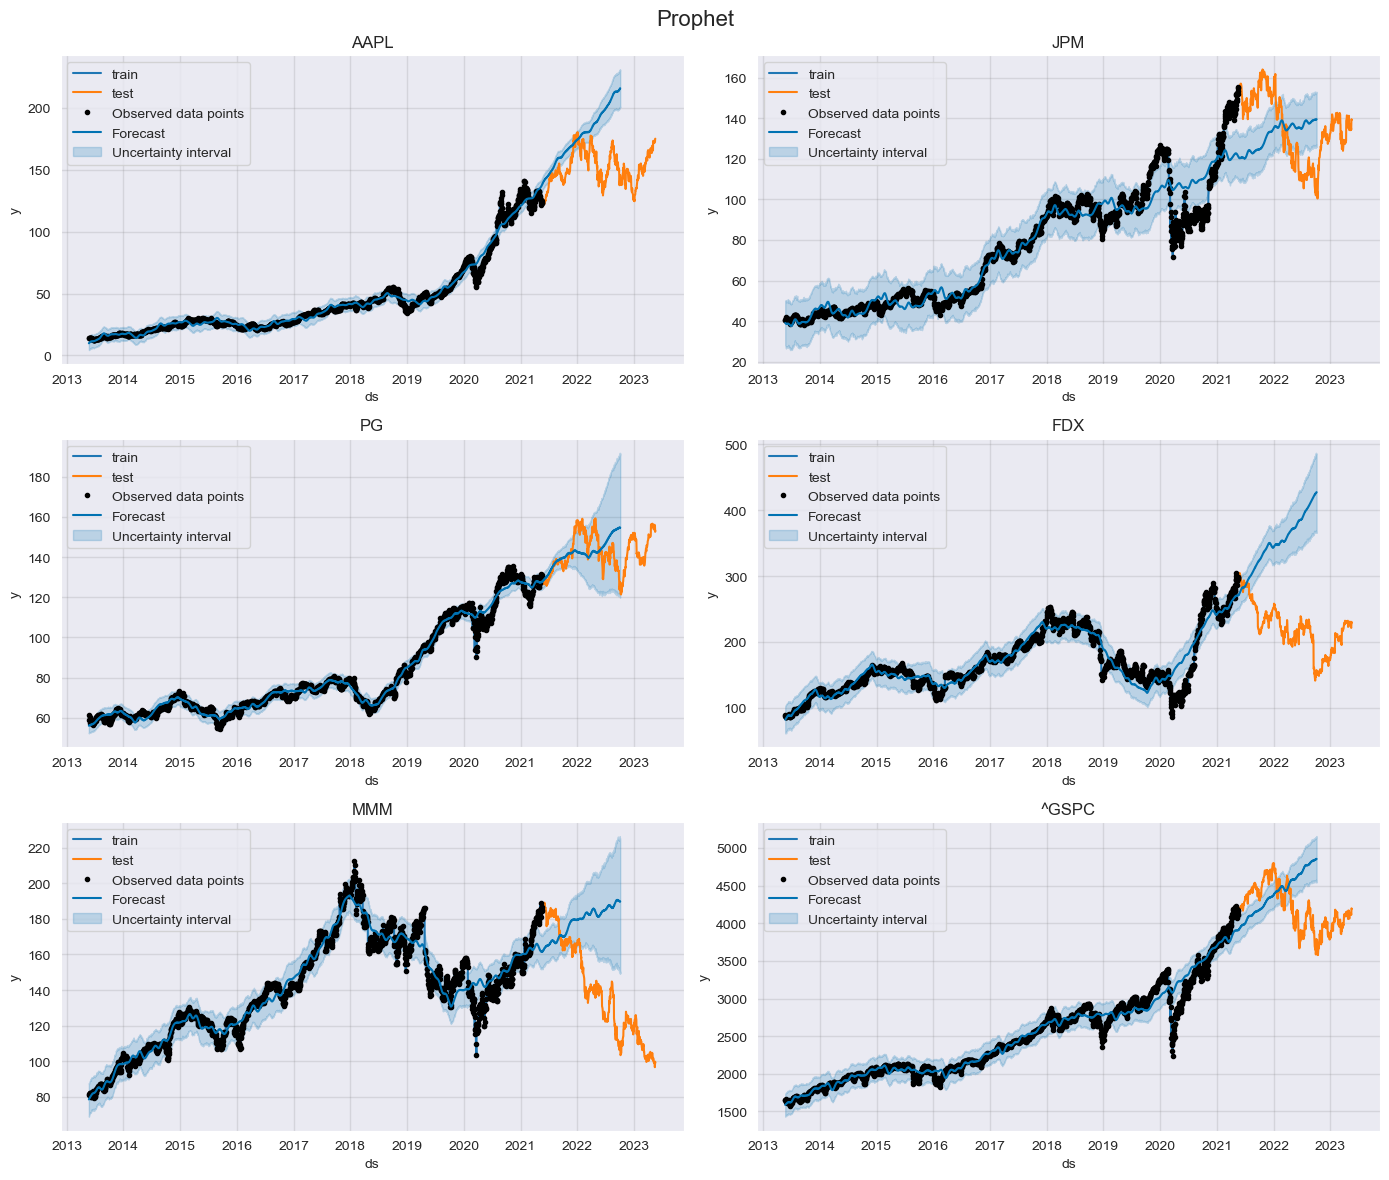

AAPL     JPM     PG       FDX      MMM      ^GSPC
R2     -5.48   -0.80   0.18    -15.92    -2.59      -2.57
MSE  1173.22  458.46  64.00  21468.75  2666.56  296342.30
MAE    26.94   17.87   6.08    130.76    43.17     487.62

In [28]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_prophet):
    prophet_model(stocks_prophet[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:33 - cmdstanpy - INFO - Chain [1] done processing
00:00:33 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:34 - cmdstanpy - INFO - Chain [1] done processing
00:00:34 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:35 - cmdstanpy - INFO - Chain [1] done processing
00:00:35 - cmdstanpy - INFO - Chain [1] start processing
00:00:36 - cmdstanpy - INFO - Chain [1] done processing


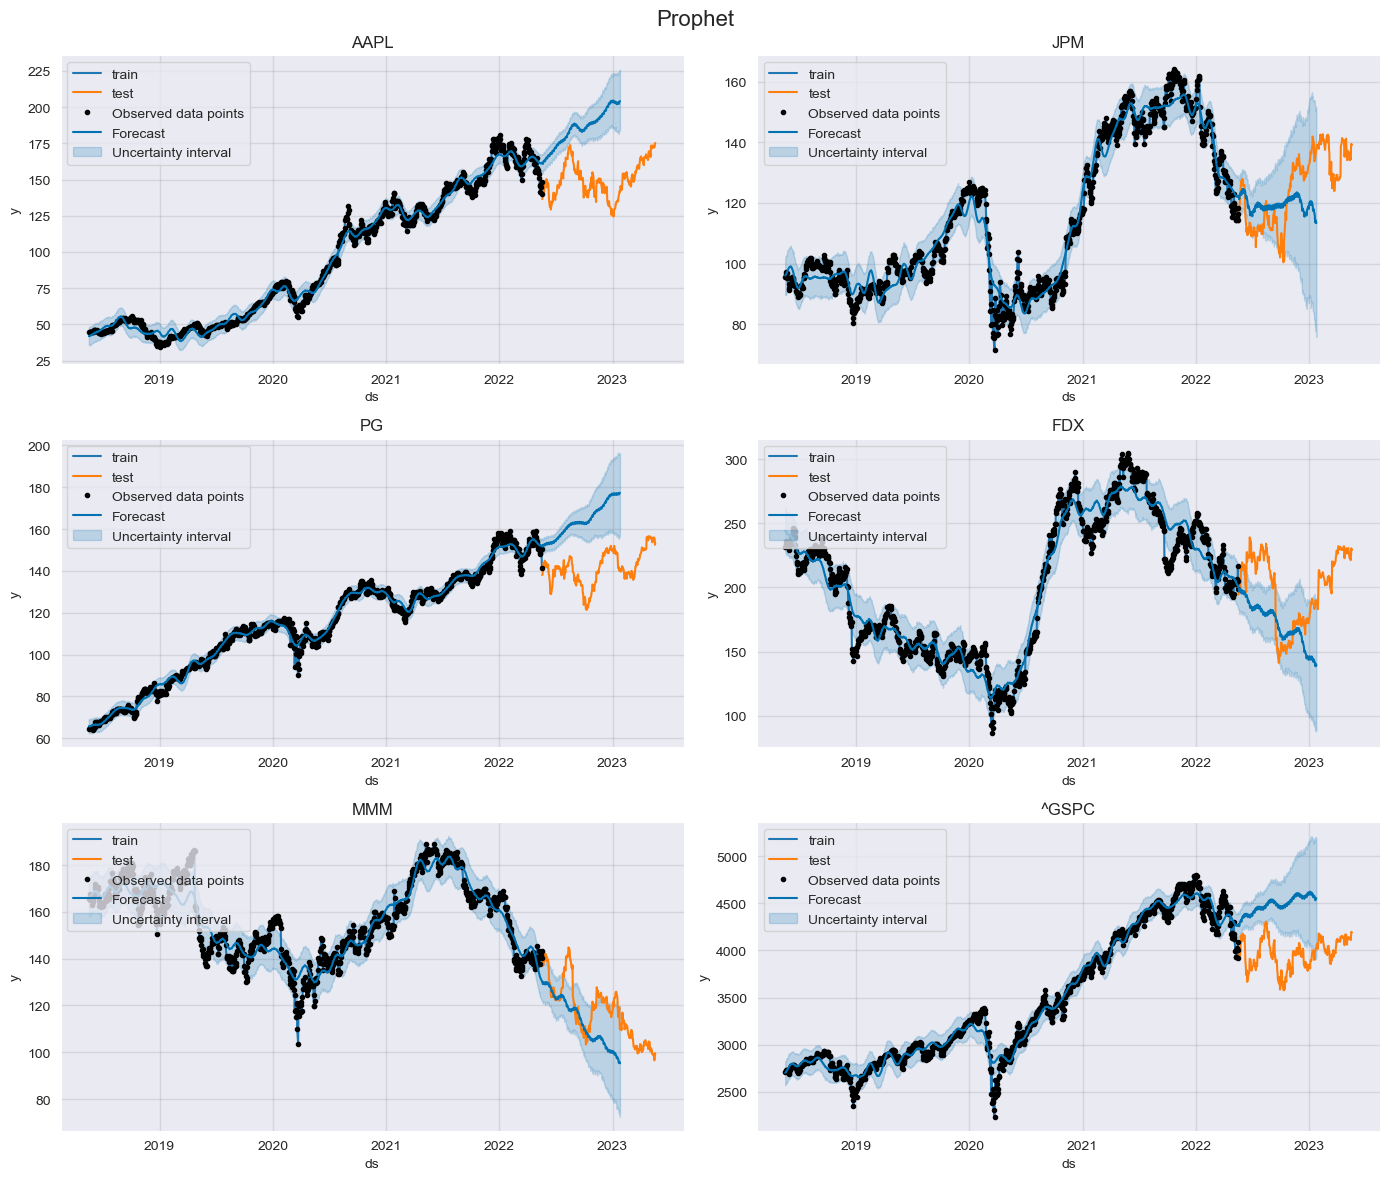

AAPL     JPM      PG      FDX    MMM      ^GSPC
R2     -8.90   -0.15   -8.13    -1.52   0.47     -11.32
MSE  1414.91  156.43  581.98  1875.94  79.99  299061.80
MAE    35.12   11.10   22.58    36.20   7.20     521.83

In [29]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_prophet):
    prophet_model(stocks_prophet[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:37 - cmdstanpy - INFO - Chain [1] start processing
00:00:37 - cmdstanpy - INFO - Chain [1] done processing
00:00:38 - cmdstanpy - INFO - Chain [1] start processing
00:00:38 - cmdstanpy - INFO - Chain [1] done processing


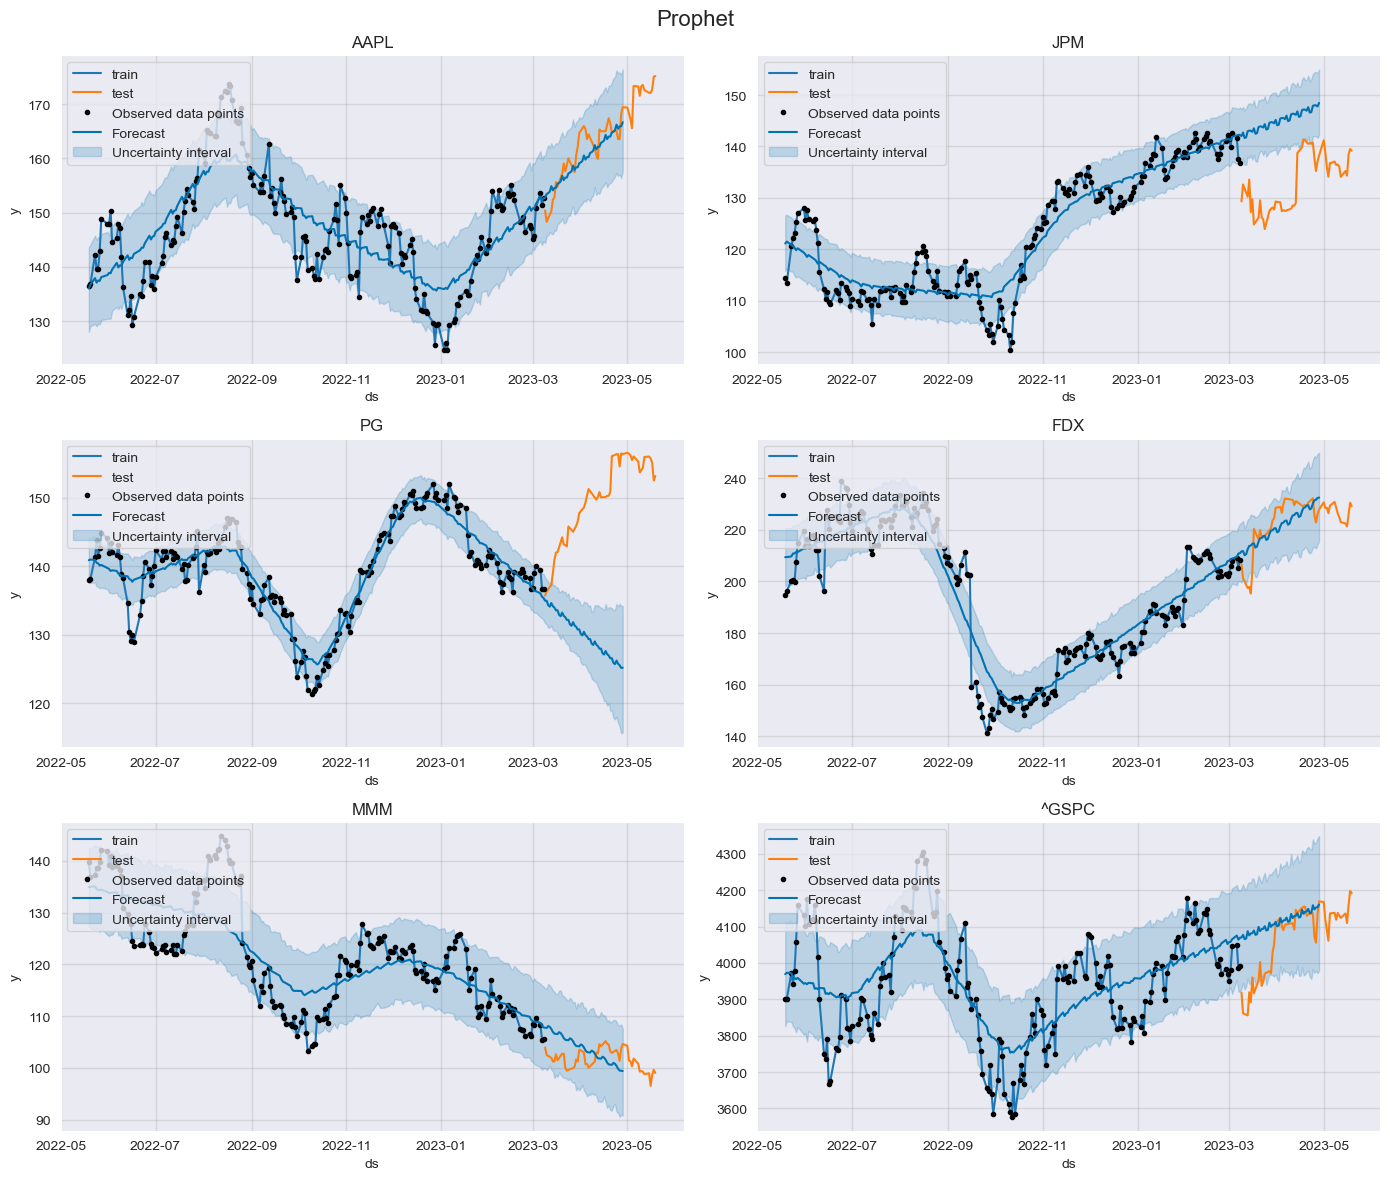

AAPL     JPM      PG    FDX    MMM    ^GSPC
R2    0.36   -4.67  -12.18   0.36  -2.14     0.17
MSE  29.82  160.09  464.38  57.03  11.87  7072.00
MAE   4.81   11.91   19.72   6.36   2.71    59.03

In [30]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks_prophet):
    prophet_model(stocks_prophet[stock][-last_year:], ax)

plt.show()
results_df

# ARIMA

In [31]:
def arima_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)

    model = pm.auto_arima(y_train, error_action='ignore', trace=True, suppress_warnings=True, maxiter=50, seasonal=False)
    model.fit(y_train)

    y_pred, conf_int = model.predict(n_periods=len(y_test), return_conf_int=True)
    y_pred_values = pd.DataFrame(y_pred, index=X_test, columns=['yhat'])

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='predictions')
    ax.fill_between(X_test, conf_int[:, 0], conf_int[:, 1], alpha=0.3)
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred_values.yhat.values)['Wartość']    

### Wyniki dla ostatnich 10 lat

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6206.509, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6273.211, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6249.084, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6250.485, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6275.717, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6251.480, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6251.486, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6255.176, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6225.540, Time=1.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6249.512, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6253.048, Time=0.54 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6253.181, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6209.257, Time=0.51 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

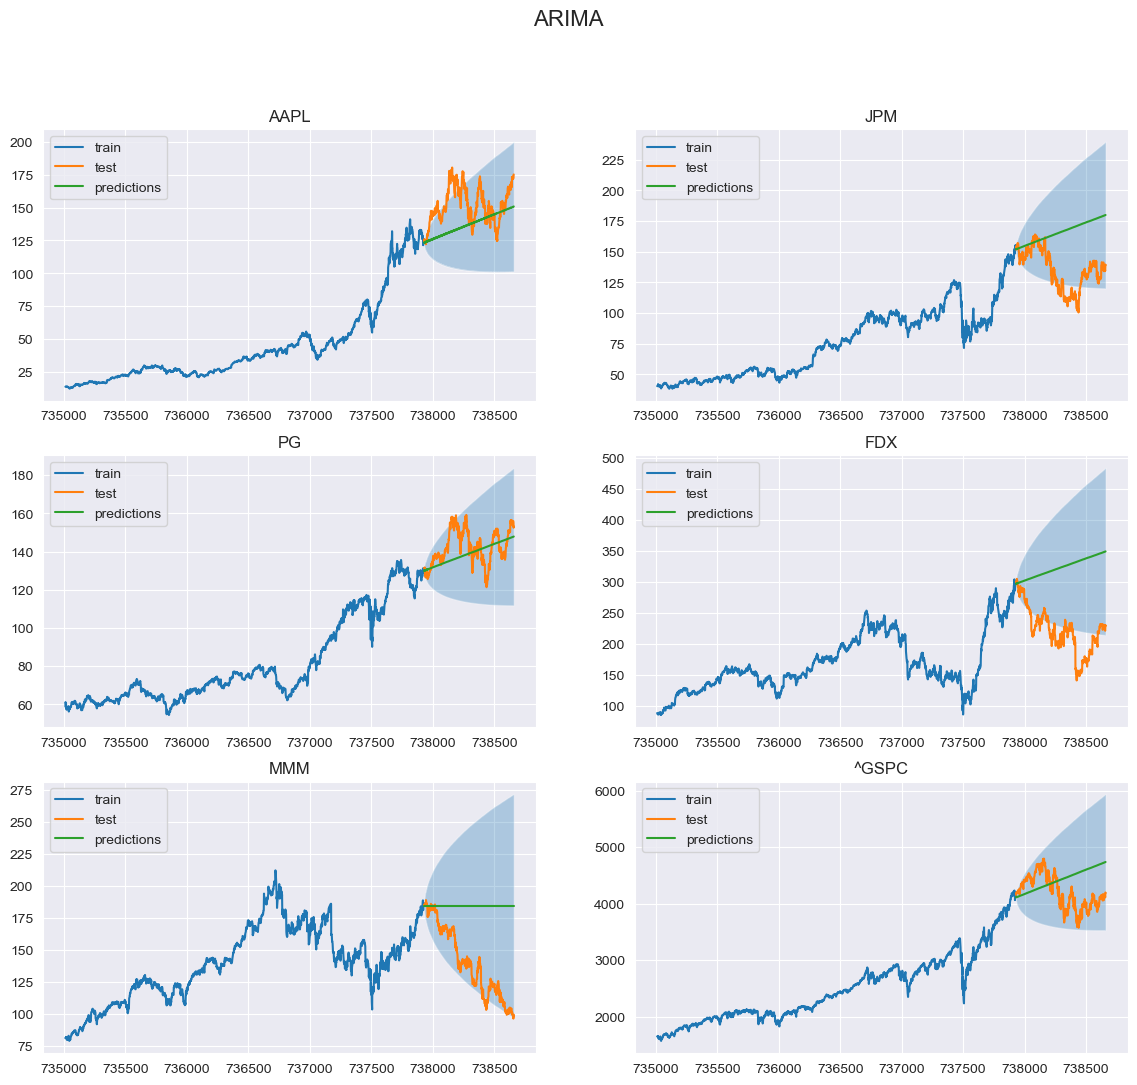

AAPL      JPM     PG       FDX      MMM      ^GSPC
R2    -1.34    -4.50  -0.14     -9.01    -2.63      -1.82
MSE  423.54  1397.63  89.17  12692.30  2695.65  233996.08
MAE   16.72    31.14   7.39    102.37    44.32     418.54

In [32]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('ARIMA', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    arima_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4331.768, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4331.370, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4326.587, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4326.589, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4331.471, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4328.587, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4328.587, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4330.584, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4327.092, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.772 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4366.816, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4398.256, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4393.864, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=439

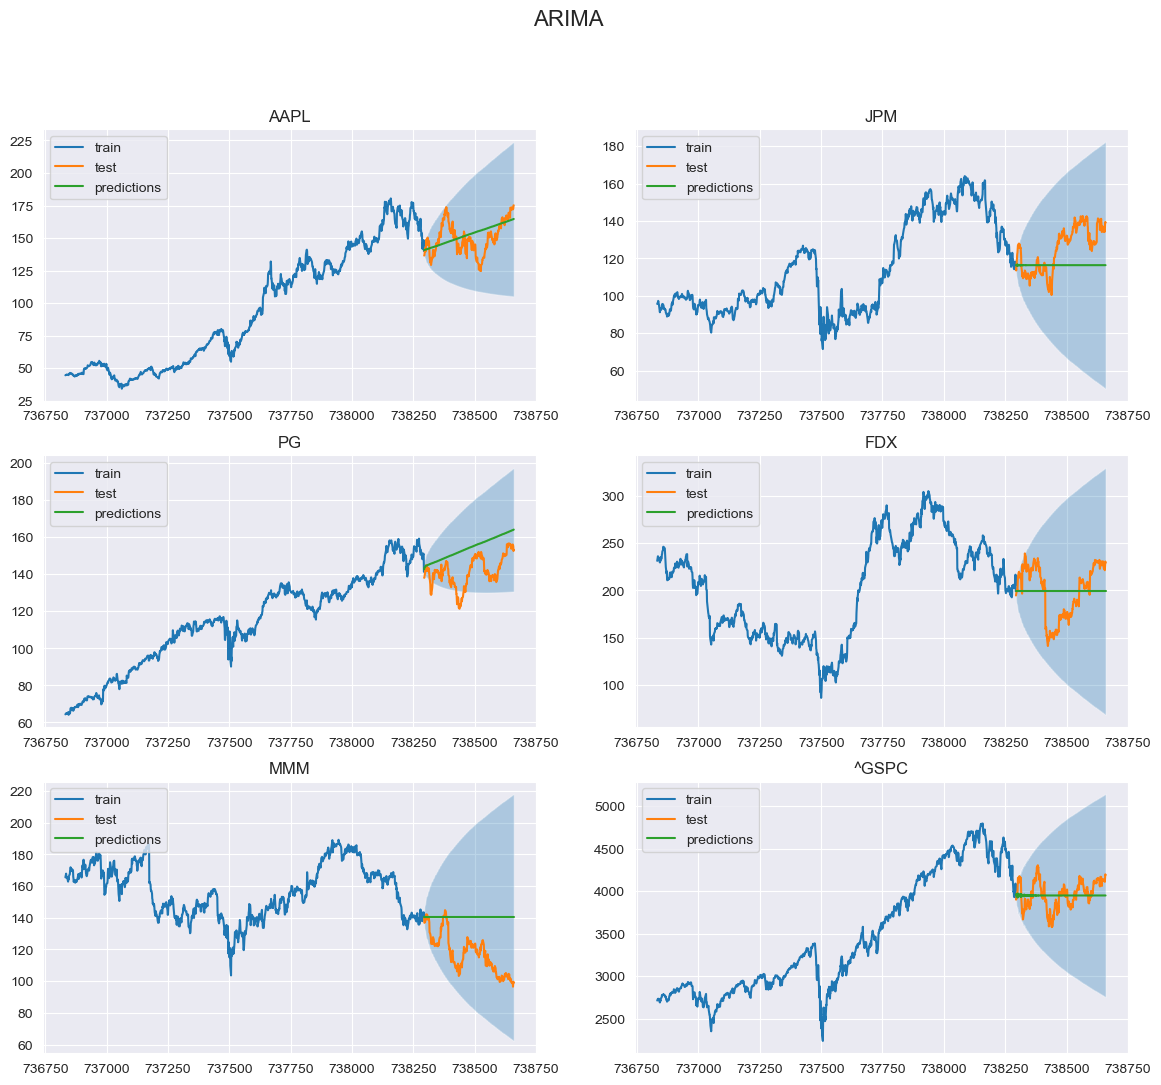

AAPL     JPM      PG     FDX     MMM     ^GSPC
R2     0.00   -0.54   -2.35   -0.00   -3.43     -0.01
MSE  142.38  208.52  213.55  744.62  671.29  24618.05
MAE    9.40   12.36   12.69   23.88   22.97    128.95

In [33]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('ARIMA', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    arima_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1025.964, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1026.033, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1027.947, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1027.929, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1024.167, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1029.427, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.197 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=851.148, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=846.482, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=846.538, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=846.552, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=845.107, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=848.505, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Tota

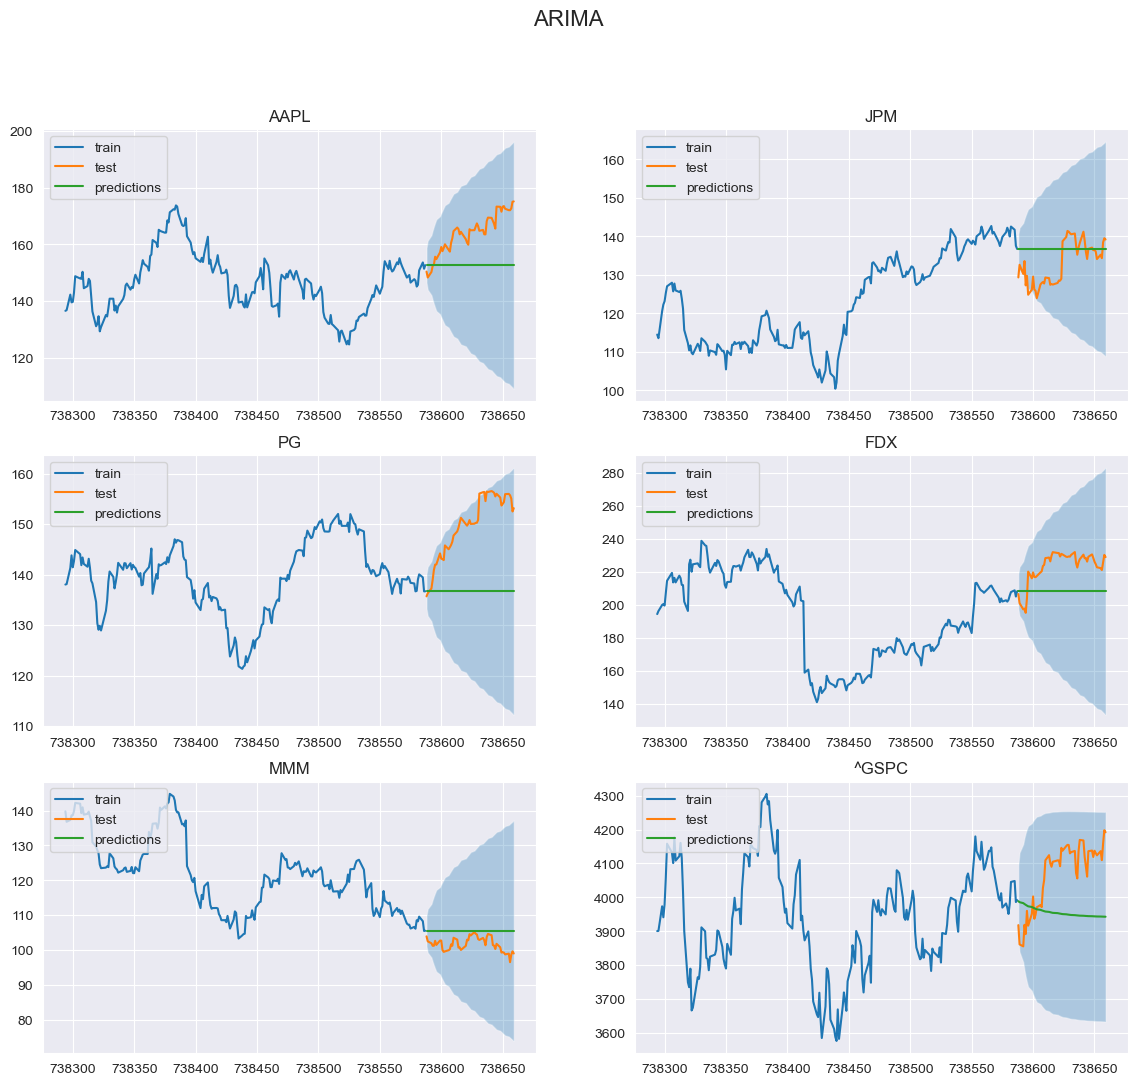

AAPL    JPM      PG     FDX    MMM     ^GSPC
R2    -2.76  -0.45   -4.83   -2.47  -4.10     -1.83
MSE  176.68  41.03  205.23  311.25  19.29  23974.33
MAE   11.76   5.26   13.09   16.76   3.94    138.85

In [34]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('ARIMA', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    arima_model(stocks[stock][-last_year:], ax)

plt.show()
results_df

# Naive Model - prognozowanie ostatniej występującej w zbiorze treningowym wartości

In [35]:
def naive_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    y_pred = np.full(len(y_test), y_train[-1]) # predicts last value from train set

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='predictions')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']


### Wyniki dla ostatnich 10 lat

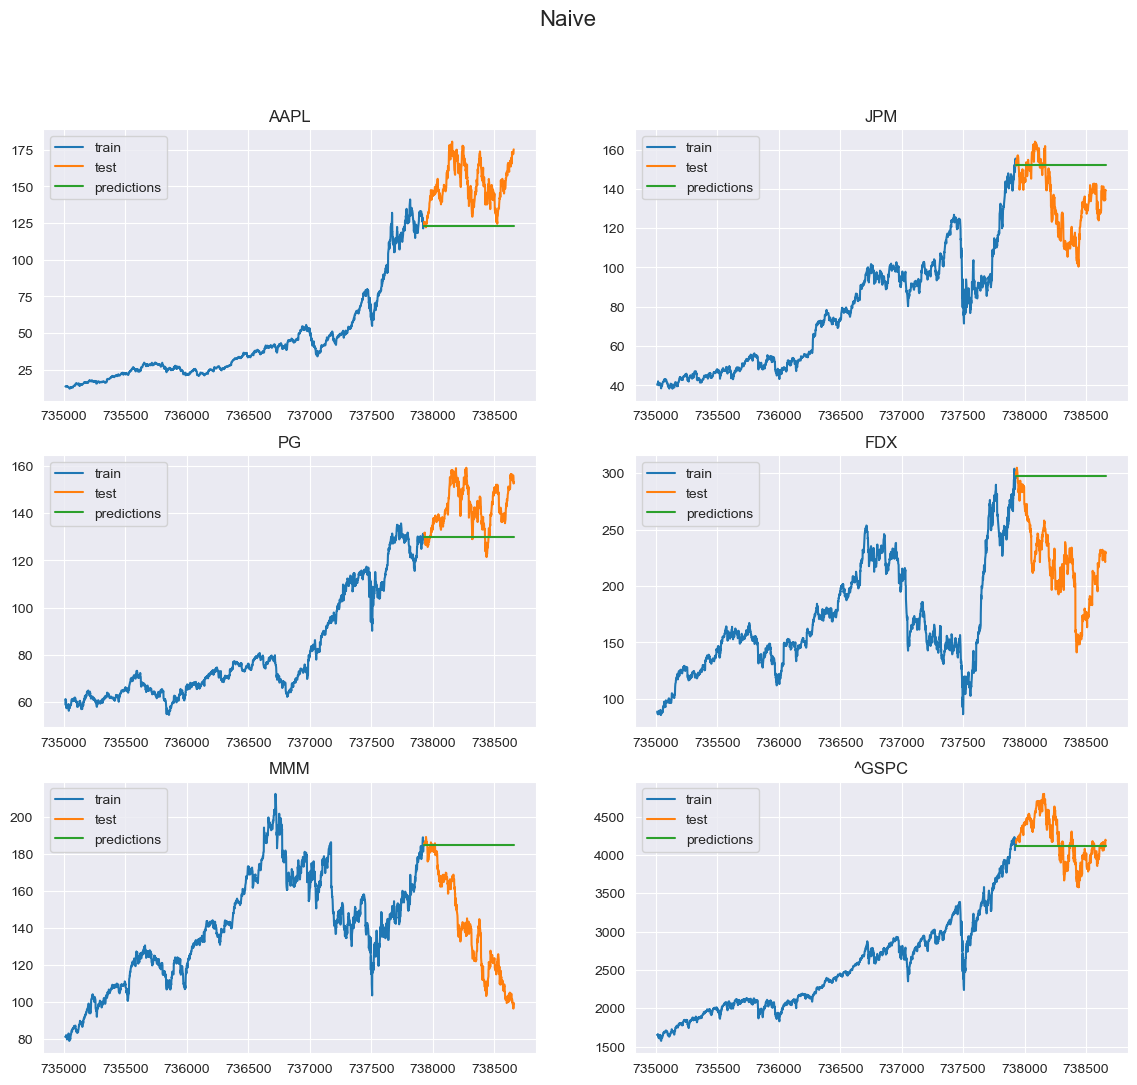

AAPL     JPM      PG      FDX      MMM     ^GSPC
R2    -4.51   -1.10   -1.88    -4.63    -2.63     -0.09
MSE  997.33  534.04  224.69  7145.89  2695.65  90244.20
MAE   28.58   18.59   12.72    76.77    44.32    247.73

In [36]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Naive', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    naive_model(stocks[stock], ax)

plt.show()
results_df

### Wyniki dla ostatnich 5 lat

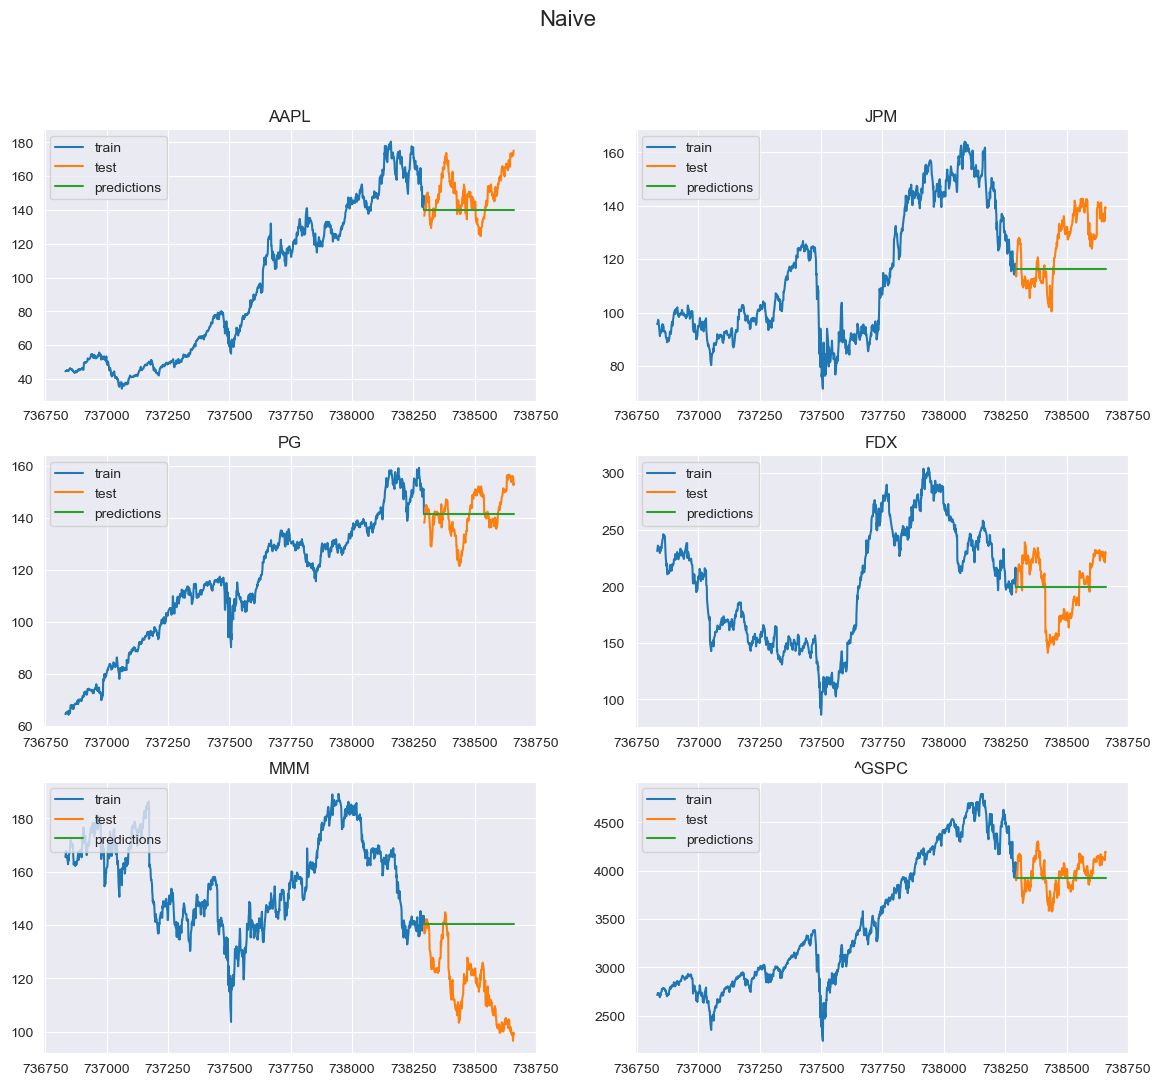

AAPL     JPM     PG     FDX     MMM     ^GSPC
R2    -0.73   -0.56  -0.00   -0.00   -3.43     -0.08
MSE  247.65  211.60  63.74  744.62  671.29  26147.13
MAE   12.64   12.42   6.22   23.88   22.97    134.44

In [37]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Naive', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    naive_model(stocks[stock][-last_5_years:], ax)

plt.show()
results_df

### Wyniki dla ostatniego roku

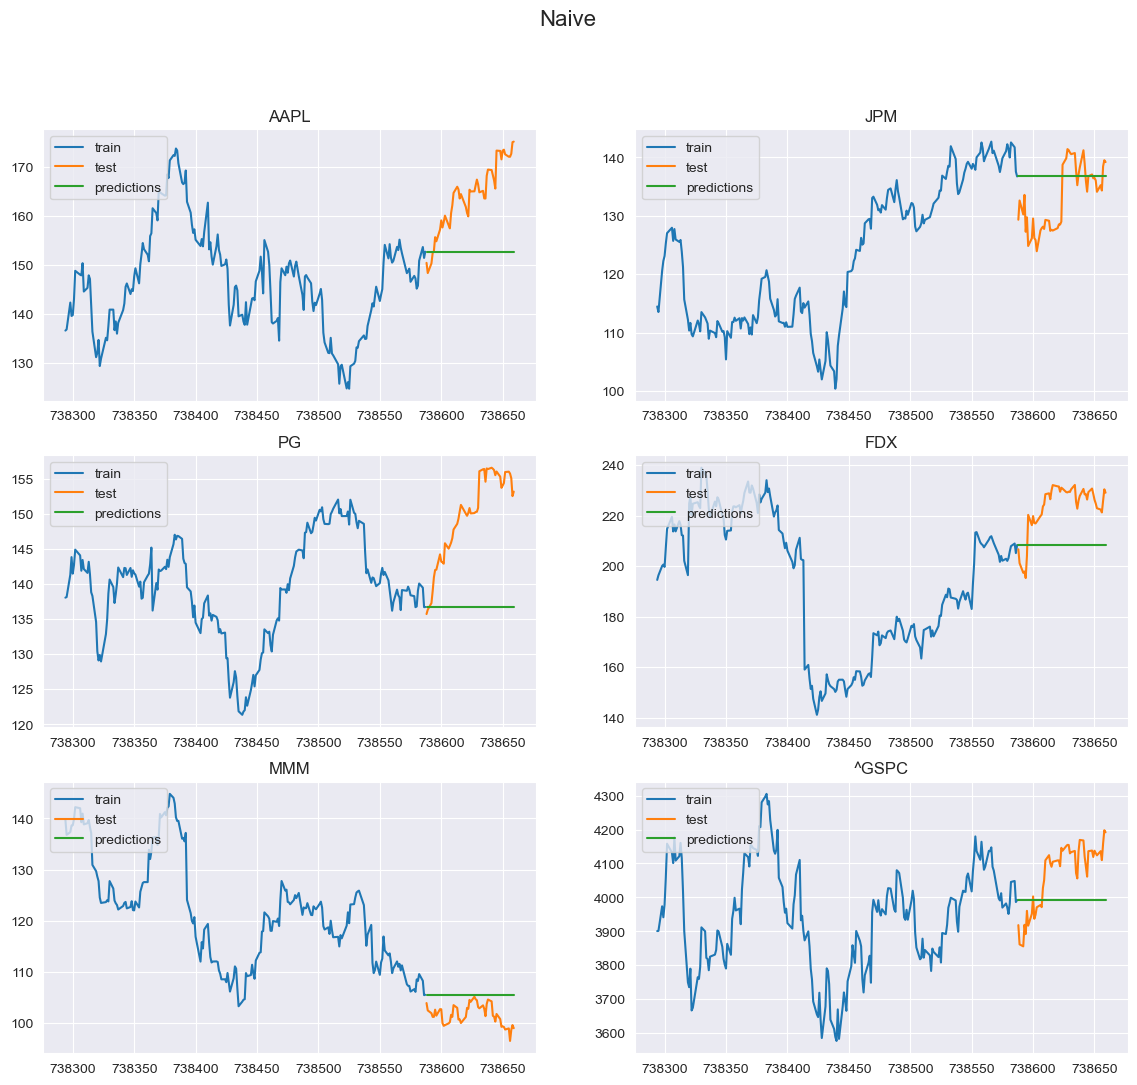

AAPL    JPM      PG     FDX    MMM     ^GSPC
R2    -2.76  -0.45   -4.83   -2.47  -4.10     -0.73
MSE  176.68  41.03  205.23  311.25  19.29  14649.21
MAE   11.76   5.26   13.09   16.76   3.94    110.55

In [38]:
results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=default_fig_size)
fig.suptitle('Naive', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    naive_model(stocks[stock][-last_year:], ax)

plt.show()
results_df